In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.colors import to_rgb
from matplotlib import gridspec
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.e5tools import *;from tools.generalTools import *
from tools.generalTools import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

from orographicConvectionTheory.orographicConvectionTheory import *
from tools.wrfHrTools import *

In [8]:
xr.set_options(display_style='text') 

# Functions, data

In [11]:
deepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfinput_d01')
deepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deepchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deepchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.days0-250.nc')
deepchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d_column


In [12]:
lmdeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
lmdeepchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
lmdeepchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.precip.days0-200.nc')
lmdeepchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d_column
lmdeephgt = lmdeepchannel.HGT.isel(south_north=0,Time=-1).persist()

In [13]:
drydeepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/')

In [14]:
hrhgt = deepinput.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-deepinput.west_east)*3


In [15]:
pT_ov_g=8000
cp=1004.
Lc=2.5e6
g=9.81

def hatprime(var,idx1,idx2):
    """Vertically average variable between two pressure levels indicated by their indices (idx1 and idx2), and take deviation from upstream value"""
    varhat = var[idx1:idx2].integrate('pressure')/(var.pressure[idx2]-var.pressure[idx1])
    return varhat - varhat[2200:2400].mean('distance_from_mtn')

## Extra data & functions

In [37]:
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
zmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.GHT_PL.days50-100.nc')

rhomean = rhomean.where(rhomean >0.)  
wmean   = wmean.where(wmean > -10)  
qmean   = qmean.where(qmean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean
zmean   = zmean.where(zmean >=0.)  

omegamean_p = change_coords_pl(hrchannel_p,omegamean)[1:-4]
tmean_p =     change_coords_pl(hrchannel_p,tmean)[1:-4]
wmean_p =     change_coords_pl(hrchannel_p,wmean)[1:-4]
zmean_p =     change_coords_pl(hrchannel_p,zmean)[1:-4]
qmean_p =     change_coords_pl(hrchannel_p,qmean)[1:-4]

In [55]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
umean = umean.where(umean >-30.)  
umean_p = change_coords_pl(hrchannel_p,umean)[1:-4]

In [12]:
tmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')
rhomean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO.days50-200.nc')
tmean_s   = change_coords_eta(hrchannel,tmean_s  )
rhomean_s = change_coords_eta(hrchannel,rhomean_s)    

    

In [8]:
lmchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.days0-200.nc')
lmchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [9]:
lmqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.Q_PL.days50-200.nc')
lmtmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.T_PL.days50-200.nc')
lmqmean   = lmqmean.where(lmqmean >0.)  
lmtmean   = lmtmean.where(lmtmean >100.)
lmtmean_p = change_coords_pl(lmchannel_p,lmtmean)
lmqmean_p = change_coords_pl(lmchannel_p,lmqmean)

In [10]:
lmtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.TEMP.days50-200.nc')
lmqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.QVAPOR.days50-200.nc')
lmtmean_s   = change_coords_eta(hrchannel,lmtmean_s  ) 
lmqmean_s   = change_coords_eta(hrchannel,lmqmean_s  )

In [11]:
aqtmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.T_PL.days50-100.nc')
aqqmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.Q_PL.days50-100.nc')
aqqmean   = aqqmean.where(aqqmean >0.)  
aqtmean   = aqtmean.where(aqtmean >100.)
aqtmean_p = change_coords_pl(lmchannel_p,aqtmean)
aqqmean_p = change_coords_pl(lmchannel_p,aqqmean)

In [12]:
aqtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.TEMP.days50-100.nc')
aqqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.QVAPOR.days50-100.nc')
aqtmean_s   = change_coords_eta(hrchannel,aqtmean_s  ) 
aqqmean_s   = change_coords_eta(hrchannel,aqqmean_s  )

In [ ]:
def plot_skewt(T,q,plevs,skew,color,lbl):
    P = np.array(plevs)* units.hPa
    Tups = units.degK*np.array(T)
    qups = np.array(q)
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)

    skew.plot(P, Tups,color=color ,label=lbl + " T")
    skew.plot(P, Tdups,color=color , linestyle='--',label=lbl + " Tdew")

    #first non-nan index
    maxcape = np.argmax(~np.isnan(np.array(T)))
    try:
        profups = mpcalc.parcel_profile(P[maxcape:], Tups[maxcape], Tdups[maxcape]).to('degC')
        skew.plot(P[maxcape:], profups, color=color, linestyle=':'  ,label=lbl+ " parcel profile")
        #skew.shade_cape(P[maxcape:], Tups[maxcape:], profups,color=color)
        print(" CAPE = %.1f J/kg"%(mpcalc.cape_cin(P[maxcape:], Tups[maxcape:], Tdups[maxcape:],profups)[0]/units("J/kg")))
    except RuntimeError:
        print('no cape')
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    skew.ax.legend()
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)

# GPM precip

In [60]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.ndimage import gaussian_filter, convolve
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [26]:
pr_trmm_all=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
pr_trmm_mean = pr_trmm_all.groupby("time.month").mean("time")
pr_trmm_plot= pr_trmm_mean.sel(latitude=slice(-30,30))
pr_trmm_plot.coords['longitude'] = (pr_trmm_plot.coords['longitude'] + 180) % 360 -180
pr_trmm_plot = pr_trmm_plot.sortby(pr_trmm_plot.longitude)
pr_trmm_plot_allm=pr_trmm_plot
pr_trmm_plot=pr_trmm_plot.mean('month')
pr_trmm_plot_jja=pr_trmm_plot_allm.sel(month=[6,7,8]).mean('month')
pr_trmm_plot_ond=pr_trmm_plot_allm.sel(month=[10,11,12]).mean('month')

In [59]:
%%time
pr_gpm_all=xr.open_mfdataset("/global/cfs/projectdirs/m3310/qnicolas/GPM-IMERG/3B-MO.MS.MRG.3IMERG.*.nc").precipitation.rename({'lat':'latitude','lon':'longitude'})
pr_gpm_mean = pr_gpm_all.sel(time=slice('2014-01-01','2020-12-31')).groupby("time.month").mean("time")
pr_gpm_plot= pr_gpm_mean.sel(latitude=slice(-30,30))
pr_gpm_plot.coords['longitude'] = (pr_gpm_plot.coords['longitude'] + 180) % 360 -180
pr_gpm_plot = pr_gpm_plot.sortby(pr_gpm_plot.longitude)
pr_gpm_plot_allm=pr_gpm_plot
pr_gpm_plot=pr_gpm_plot.mean('month')
pr_gpm_plot_jja=pr_gpm_plot_allm.sel(month=[6,7,8]).mean('month').persist()
pr_gpm_plot_ond=pr_gpm_plot_allm.sel(month=[10,11,12]).mean('month').persist()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 3.8 s, sys: 7.48 s, total: 11.3 s
Wall time: 7.07 s


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [61]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665
orog_plot = orog.reindex(latitude=list(reversed(orog.latitude))).sel(latitude=slice(-30,30))
orog_plot.coords['longitude'] = (orog_plot.coords['longitude'] + 180) % 360 -180
orog_plot = orog_plot.sortby(orog_plot.longitude)
orog_plot_smooth=xr.apply_ufunc(gaussian_filter,orog_plot  ,kwargs={"sigma":1.5})

In [62]:
era5100u= e5_climatology("*_100u",years=range(1998,2014))
era5100v= e5_climatology("*_100v",years=range(1998,2014))

5.789562225341797
6.291652202606201


In [63]:
u100plot=era5100u.sel(latitude=slice(30,-30))
v100plot=era5100v.sel(latitude=slice(30,-30))

u100plot.coords['longitude'] = (u100plot.coords['longitude'] + 180) % 360 -180
u100plot = u100plot.sortby(u100plot.longitude)
v100plot.coords['longitude'] = (v100plot.coords['longitude'] + 180) % 360 -180
v100plot = v100plot.sortby(v100plot.longitude)


In [64]:
u100plot_jja = u100plot.sel(month=[6,7,8]).mean('month')
v100plot_jja = v100plot.sel(month=[6,7,8]).mean('month')

u100plot_ond = u100plot.sel(month=[10,11,12]).mean('month')
v100plot_ond = v100plot.sel(month=[10,11,12]).mean('month')

In [65]:
def cross_section(lon1,lon2,lat,ax):
    ax2=ax.twinx()
    pr_gpm_plot_jja.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='g',label='JJA precipitation',linewidth=3)#
    pr_gpm_plot_ond.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='dodgerblue',label='OND precipitation',linewidth=3)#
    orog_plot.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax,color='k',label='Surface elevation',linewidth=3)#
    ax.set_xlabel('')
    ticklon=range(lon1,lon2,10)[1:]
    ax.set_xticks(ticklon)
    ax.set_xticklabels(["%i°E"%t for t in ticklon])
    ax.set_ylabel('Z (m)')
    ax2.set_ylabel('precipitation (mm/day)')
    ax.set_title('Cross-section at %i°N'%lat,fontsize=20)
    ax.set_title('')
    ax2.set_title('')
    ax.set_xlim((lon1,lon2))
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    return ax2


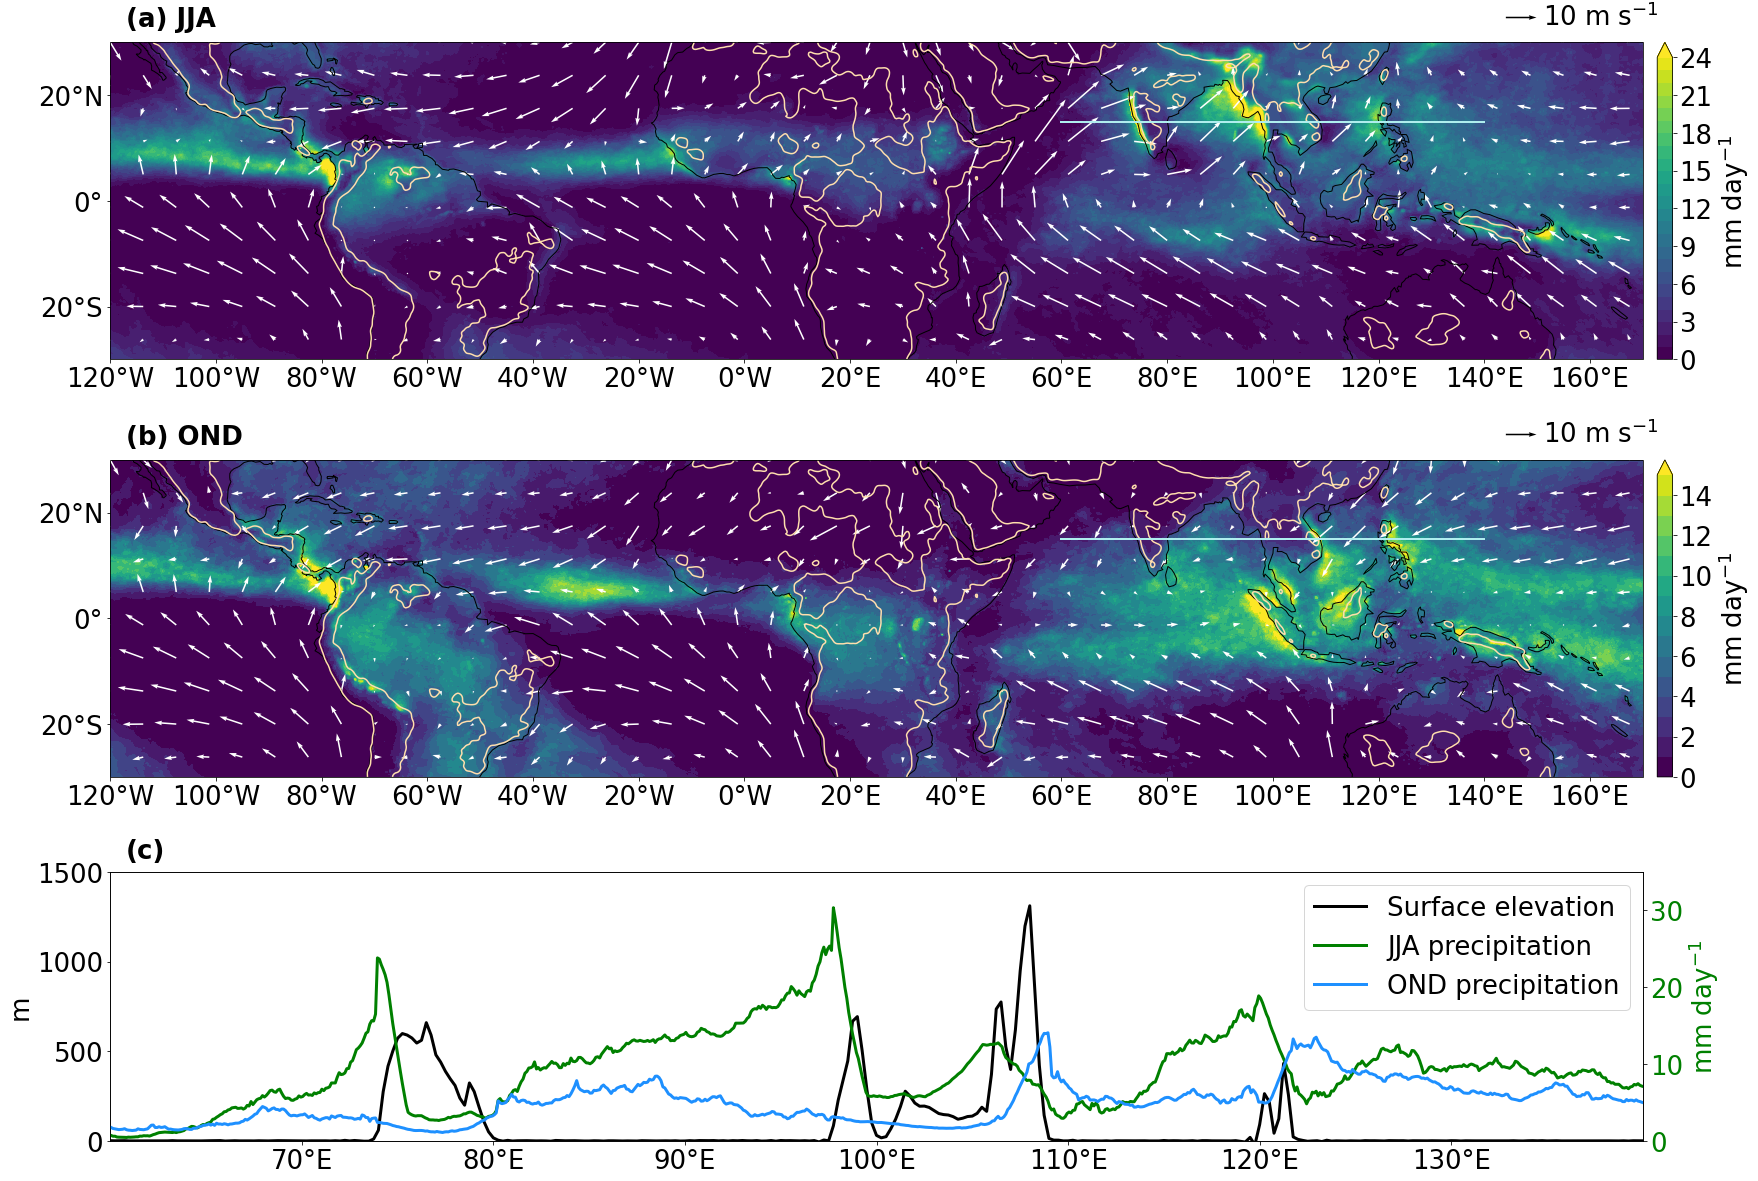

In [66]:
matplotlib.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=(25,17))
spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios= [5,5,4.1],figure=fig)
ax = fig.add_subplot(spec[0],projection= ccrs.PlateCarree())
ax1 = fig.add_subplot(spec[1],projection= ccrs.PlateCarree())
ax2 = fig.add_subplot(spec[2])

cf =pr_gpm_plot_jja.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,25.,1.),add_colorbar=False)#,cbar_kwargs={'label':r'mm day$^{-1}$'}
cf1=pr_gpm_plot_ond.sel(longitude=slice(-120,170)).plot.contourf(ax=ax1,levels=np.arange(0.,16.,1.),add_colorbar=False)#,cbar_kwargs={'label':r'mm day$^{-1}$'}

for a,c,uplot,vplot in (ax,cf,u100plot_jja,v100plot_jja),(ax1,cf1,u100plot_ond,v100plot_ond):
    orog_plot_smooth.sel(longitude=slice(-120,170)).plot.contour(ax=a,levels=[500.],colors='navajowhite',linewidths=[1.5])
    
    u=uplot.sel(longitude=slice(-120,170))
    v=vplot.sel(longitude=slice(-120,170))
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=25
    m=n
    Q = a.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="w",width=0.001,scale=500)

    
    a.plot([60,140],[15,15],color='paleturquoise',linewidth=2)
    a.coastlines()
    a.set_ylim(-30,30)
    a.set_xlim(-120,170)
    a.set_title("")
    a.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
    a.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    a.xaxis.set_major_formatter(lon_formatter)
    a.yaxis.set_major_formatter(lat_formatter)
    a.set_xlabel("")
    a.set_ylabel("")
    
    pad=.2;size="1%"
    
    divider = make_axes_locatable(a)
    cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    plt.colorbar(c, cax=cax,label=r'mm day$^{-1}$')

    qk = a.quiverkey(Q, 0.93, 1.08, 10, r'10 m s$^{-1}$', labelpos='E',
                       coordinates='axes',color='k')
ax.text(0.01, 1.05,'(a) JJA', transform=ax.transAxes,color='k',weight='bold')
ax1.text(0.01, 1.05,'(b) OND', transform=ax1.transAxes,color='k',weight='bold')
#rw=0.15
#ax.add_patch(plt.Rectangle((0,1-rw), rw/5, rw, fc='w',ec='w',transform=ax.transAxes,zorder=2))
#ax.text(0.001, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')


ax3=cross_section(60,140,15,ax2)
for a in ax2,ax3:
    divider2 = make_axes_locatable(a)
    cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    cax2.remove()
ax2.set_ylim(0,1500)
ax3.set_ylim(0,35)
ax2.set_ylabel("m")
ax3.tick_params(axis ='y', labelcolor = 'g')
ax3.set_ylabel(r'mm day$^{-1}$',color='g')
ax3.text(0.01, 1.05,'(c)', transform=ax3.transAxes,color='k',weight='bold')

fig.tight_layout()
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/trmmOrog.png', dpi=300 ,bbox_inches='tight')

Text(0.01, 1.05, '(c)')

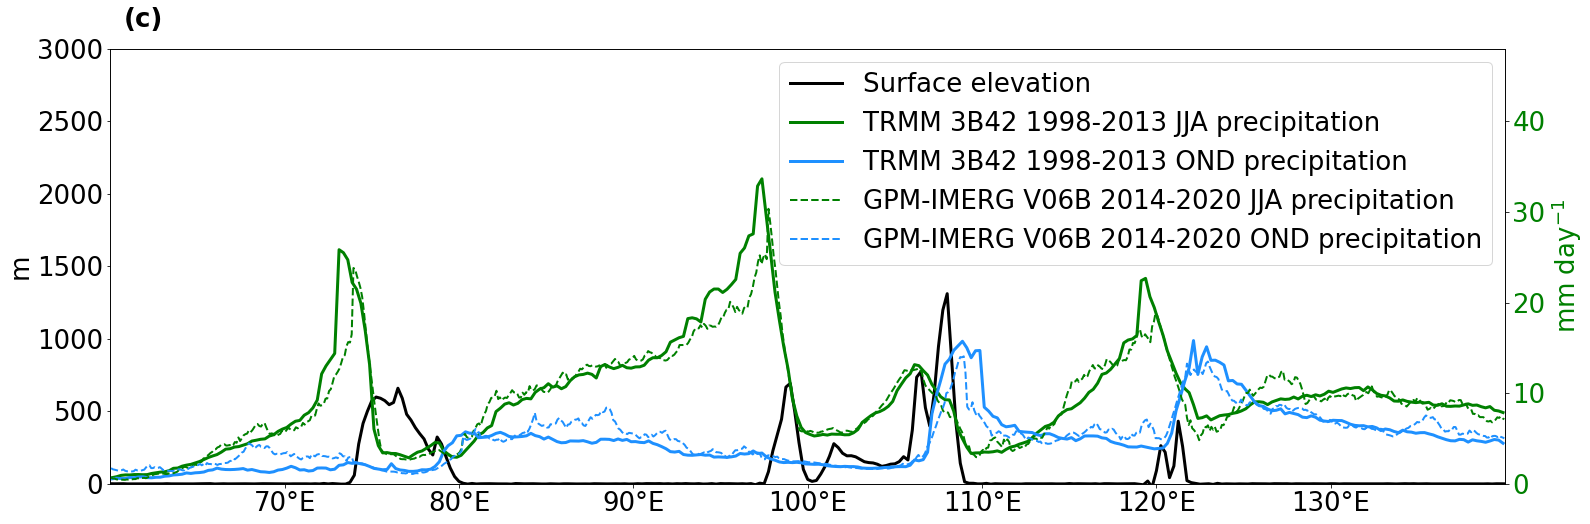

In [35]:
def cross_section_2(lon1,lon2,lat,ax):
    ax2=ax.twinx()
    pr_trmm_plot_jja.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='g',label='TRMM 3B42 1998-2013 JJA precipitation',linewidth=3)#
    pr_trmm_plot_ond.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='dodgerblue',label='TRMM 3B42 1998-2013 OND precipitation',linewidth=3)#
    pr_gpm_plot_jja.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,linestyle='--',color='g',label='GPM-IMERG V06B 2014-2020 JJA precipitation',linewidth=2)#
    pr_gpm_plot_ond.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,linestyle='--',color='dodgerblue',label='GPM-IMERG V06B 2014-2020 OND precipitation',linewidth=2)#
    orog_plot.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax,color='k',label='Surface elevation',linewidth=3)#
    ax.set_xlabel('')
    ticklon=range(lon1,lon2,10)[1:]
    ax.set_xticks(ticklon)
    ax.set_xticklabels(["%i°E"%t for t in ticklon])
    ax.set_ylabel('Z (m)')
    ax2.set_ylabel('precipitation (mm/day)')
    ax.set_title('Cross-section at %i°N'%lat,fontsize=20)
    ax.set_title('')
    ax2.set_title('')
    ax.set_xlim((lon1,lon2))
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=1)
    return ax2

_,ax2=plt.subplots(1,1,figsize=(25,8))
ax3=cross_section_2(60,140,15,ax2)

ax2.set_ylim(0,3000)
ax3.set_ylim(0,48)
ax2.set_ylabel("m")
ax3.tick_params(axis ='y', labelcolor = 'g')
ax3.set_ylabel(r'mm day$^{-1}$',color='g')
ax3.text(0.01, 1.05,'(c)', transform=ax3.transAxes,color='k',weight='bold')


# Figure 2 - Theory precip

In [6]:
from orographicConvectionTheory.orographicConvectionTheory import *
def analytical_precip(U,a=100e3,A=1000,tauT=3,tauq=11,P0 = 4.):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    
    xx=np.arange(-10000e3,20000e3,5e3)
    
    tauT*=3600
    tauq*=3600
    
    Lq=compute_Lq(5,U,tauq)
    
    ds0dz,dq0dz,N = lapse_rates()
    chi = pT_ov_g * (ds0dz/tauT - dq0dz/tauq)/ Lc * 86400
    print(chi*Lq)
    
    zbot=1000
    ztop=3000
    l=N/U
    s=(np.cos(l*zbot)-np.cos(l*ztop))/(l*ztop-l*zbot)

    return xx,P0+chi*s*A*a/(2*Lq)*np.abs(Lq/xx)**2

In [7]:
xx,hx = topographic_profile(kind='agnesi',a=50e3,A=1000)
P1000 = linear_precip_theory(xx,hx,10)
P500   = linear_precip_theory(xx,hx/2,10)
Ptau   = linear_precip_theory(xx,hx,10,tauT=4.5,tauq=16.5)
P1000_nodamp = linear_precip_theory(xx,hx,10,switch=1e-4)

xa,P1000_a = analytical_precip(10,a=50e3)
xa,Ptau_a  = analytical_precip(10,a=50e3,tauT=4.5,tauq=16.5)
xa,P500_a  = analytical_precip(10,a=50e3,A=500)

158960.25460817563
158960.2546081756
158960.25460817563


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


In [8]:
print(r"$h_0=1000$ m, $\tau_T=3$ hr,$\tau_q=11$ hr     : true xu = %i km, analytical = %i km"%(xx[np.argmax(P1000>5.)]/1e3,xx[np.argmax(P1000_a>5.)]/1e3))
print(r"$h_0=1000$ m, $\tau_T=4.5$ hr,$\tau_q=16.5$ hr : true xu = %i km, analytical = %i km"%(xx[np.argmax(Ptau>5.)]/1e3,xx[np.argmax(Ptau_a>5.)]/1e3))
print(r"$h_0=500$ m, $\tau_T=3$ hr,$\tau_q=11$ hr      : true xu = %i km, analytical = %i km"%(xx[np.argmax(P500>5.)]/1e3,xx[np.argmax(P500_a>5.)]/1e3))

$h_0=1000$ m, $\tau_T=3$ hr,$\tau_q=11$ hr     : true xu = -1705 km, analytical = -1750 km
$h_0=1000$ m, $\tau_T=4.5$ hr,$\tau_q=16.5$ hr : true xu = -1485 km, analytical = -1750 km
$h_0=500$ m, $\tau_T=3$ hr,$\tau_q=11$ hr      : true xu = -1055 km, analytical = -1240 km


In [9]:
_,hx2 = topographic_profile(kind='agnesi',a=200e3,A=1000)
Ptau2   = linear_precip_theory(xx,hx2,10,tauT=4.5,tauq=4)
_,Ptau_a2  = analytical_precip(10,a=200e3,tauT=4.5,tauq=4)
print("true xu = %i km, analytical = %i km"%(xx[np.argmax(Ptau2>5.)]/1e3,xx[np.argmax(Ptau_a2>5.)]/1e3))


89563.77460817563
true xu = -3305 km, analytical = -2630 km


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


In [10]:
print(r"$h_0=1000$ m, $\tau_T=3$ hr,$\tau_q=11$ hr     : true xu = %i km, analytical = %i km"%(xx[np.argmax(P1000>5.)]/1e3,xx[np.argmax(P1000_a>5.)]/1e3))
print(r"$h_0=1000$ m, $\tau_T=4.5$ hr,$\tau_q=16.5$ hr : true xu = %i km, analytical = %i km"%(xx[np.argmax(Ptau>5.)]/1e3,xx[np.argmax(Ptau_a>5.)]/1e3))
print(r"$h_0=500$ m, $\tau_T=3$ hr,$\tau_q=11$ hr      : true xu = %i km, analytical = %i km"%(xx[np.argmax(P500>5.)]/1e3,xx[np.argmax(P500_a>5.)]/1e3))

$h_0=1000$ m, $\tau_T=3$ hr,$\tau_q=11$ hr     : true xu = -1705 km, analytical = -1750 km
$h_0=1000$ m, $\tau_T=4.5$ hr,$\tau_q=16.5$ hr : true xu = -1485 km, analytical = -1750 km
$h_0=500$ m, $\tau_T=3$ hr,$\tau_q=11$ hr      : true xu = -1055 km, analytical = -1240 km


In [ ]:
matplotlib.rcParams.update({'font.size': 26})
fig,ax=plt.subplots(1,1,figsize=(25,6))
ax2=ax.twinx()

# precips
ax.plot(xx/1000,P1000,label=r"P with $h_0=1000$ m, $\tau_T=3$ hr,$\tau_q=11$ hr"    ,color='navy',linewidth=3)
ax.plot(xx/1000,Ptau ,label=r"P with $h_0=1000$ m, $\tau_T=4.5$ hr,$\tau_q=16.5$ hr",color='dodgerblue',linewidth=3)
ax.plot(xx/1000,P500 ,label=r"P with $h_0=500$ m, $\tau_T=3$ hr,$\tau_q=11$ hr"     ,color='turquoise',linewidth=3)

ax.plot(xx/1000,P1000_nodamp,linestyle='--',color='navy',linewidth=2)

#ax.plot(xa/1000,P1000_a,linestyle=':',color='navy',linewidth=2)
#ax.plot(xa/1000,Ptau_a, linestyle=':',color='dodgerblue',linewidth=2)
#ax.plot(xa/1000,P500_a, linestyle=':',color='turquoise',linewidth=2)

# mountain
ax2.plot(xx/1000,hx/1000,label=r"$h(x)/h_0$",color='gray',linewidth=2)

# Decoration
ax.axhline(4.,linewidth=0.5,color='navy')
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel(r'mm day$^{-1}$')
ax.set_xlim(-2.1e3,3.1e3)
ax.set_ylim(0,40)


ax2.set_ylabel('nondimensional height')
ax2.set_ylim(0,3)
ax2.set_yticks([0,1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=1,fontsize=24)
#fig.savefig('figures_review/analyticalAgnesi.eps',bbox_inches='tight')

# Figure 3 - WRF Precip & CAPE

In [12]:
deeppr=deepchannelprecip.isel(Time=slice(400,1001)).mean(['Time','south_north']).load()
deepcape=deepchannel_capecin[0].isel(Time=slice(400,1001)).mean(['Time','south_north']).load()

In [13]:
%%time
deeppr_intervals   = np.zeros((15,len(deepchannel.west_east)))
deepcape_intervals = np.zeros((15,len(deepchannel.west_east)))
for i,t in enumerate(range(400,1000,40)):
    deeppr_intervals[i]  =np.array(deepchannelprecip.isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())
    deepcape_intervals[i]=np.array(deepchannel_capecin[0].isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())
deeppr_percentiles = xr.DataArray([np.percentile(deeppr_intervals,25,axis=0),np.percentile(deeppr_intervals,75,axis=0)],dims=['percentile','west_east'],coords={'percentile':('percentile',[25,75])},attrs={'name':'Precipitation','units':'mm/day'})
deepcape_percentiles = xr.DataArray([np.percentile(deepcape_intervals,25,axis=0),np.percentile(deepcape_intervals,75,axis=0)],dims=['percentile','west_east'],coords={'percentile':('percentile',[25,75])},attrs={'name':'CAPE','units':'J/kg'})


CPU times: user 1.38 s, sys: 1.42 s, total: 2.8 s
Wall time: 2.76 s


In [14]:
lmdeeppr=lmdeepchannelprecip.isel(Time=slice(200,801)).mean(['Time','south_north']).load()
lmdeepcape=lmdeepchannel_capecin[0].isel(Time=slice(200,801)).mean(['Time','south_north']).load()

In [15]:
%%time
lmdeeppr_intervals   = np.zeros((15,len(deepchannel.west_east)))
lmdeepcape_intervals = np.zeros((15,len(deepchannel.west_east)))
for i,t in enumerate(range(200,800,40)):
    lmdeeppr_intervals[i]  =np.array(lmdeepchannelprecip.isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())
    lmdeepcape_intervals[i]=np.array(lmdeepchannel_capecin[0].isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())
lmdeeppr_percentiles = xr.DataArray(  [np.percentile(lmdeeppr_intervals,25,axis=0)  ,np.percentile(lmdeeppr_intervals,75,axis=0)],dims=['percentile','west_east'],coords={'percentile':('percentile',[25,75])},attrs={'name':'Precipitation','units':'mm/day'})
lmdeepcape_percentiles = xr.DataArray([np.percentile(lmdeepcape_intervals,25,axis=0),np.percentile(lmdeepcape_intervals,75,axis=0)],dims=['percentile','west_east'],coords={'percentile':('percentile',[25,75])},attrs={'name':'CAPE','units':'J/kg'})


CPU times: user 1.47 s, sys: 1.46 s, total: 2.93 s
Wall time: 2.88 s


In [17]:
#deeppr.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
#lmdeeppr.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.500m.3km.precip.days50-200.mean.nc")
#deepcape.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.CAPE.days50-200.mean.nc")
#lmdeepcape.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.500m.3km.CAPE.days50-200.mean.nc")
#
#deeppr_percentiles.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.precip.days50-200.percentiles.nc")
#lmdeeppr_percentiles.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.500m.3km.precip.days50-200.percentiles.nc")
#deepcape_percentiles.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.CAPE.days50-200.percentiles.nc")
#lmdeepcape_percentiles.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.500m.3km.CAPE.days50-200.percentiles.nc")


In [16]:
hrpr  =xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
lmpr  =xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.500m.3km.precip.days50-200.mean.nc")
hrcape=xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.CAPE.days50-200.mean.nc")
lmcape=xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.500m.3km.CAPE.days50-200.mean.nc")

hrpr_percentiles  =xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip.days50-200.percentiles.nc")
lmpr_percentiles  =xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.500m.3km.precip.days50-200.percentiles.nc")
hrcape_percentiles=xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.CAPE.days50-200.percentiles.nc")
lmcape_percentiles=xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.500m.3km.CAPE.days50-200.percentiles.nc")


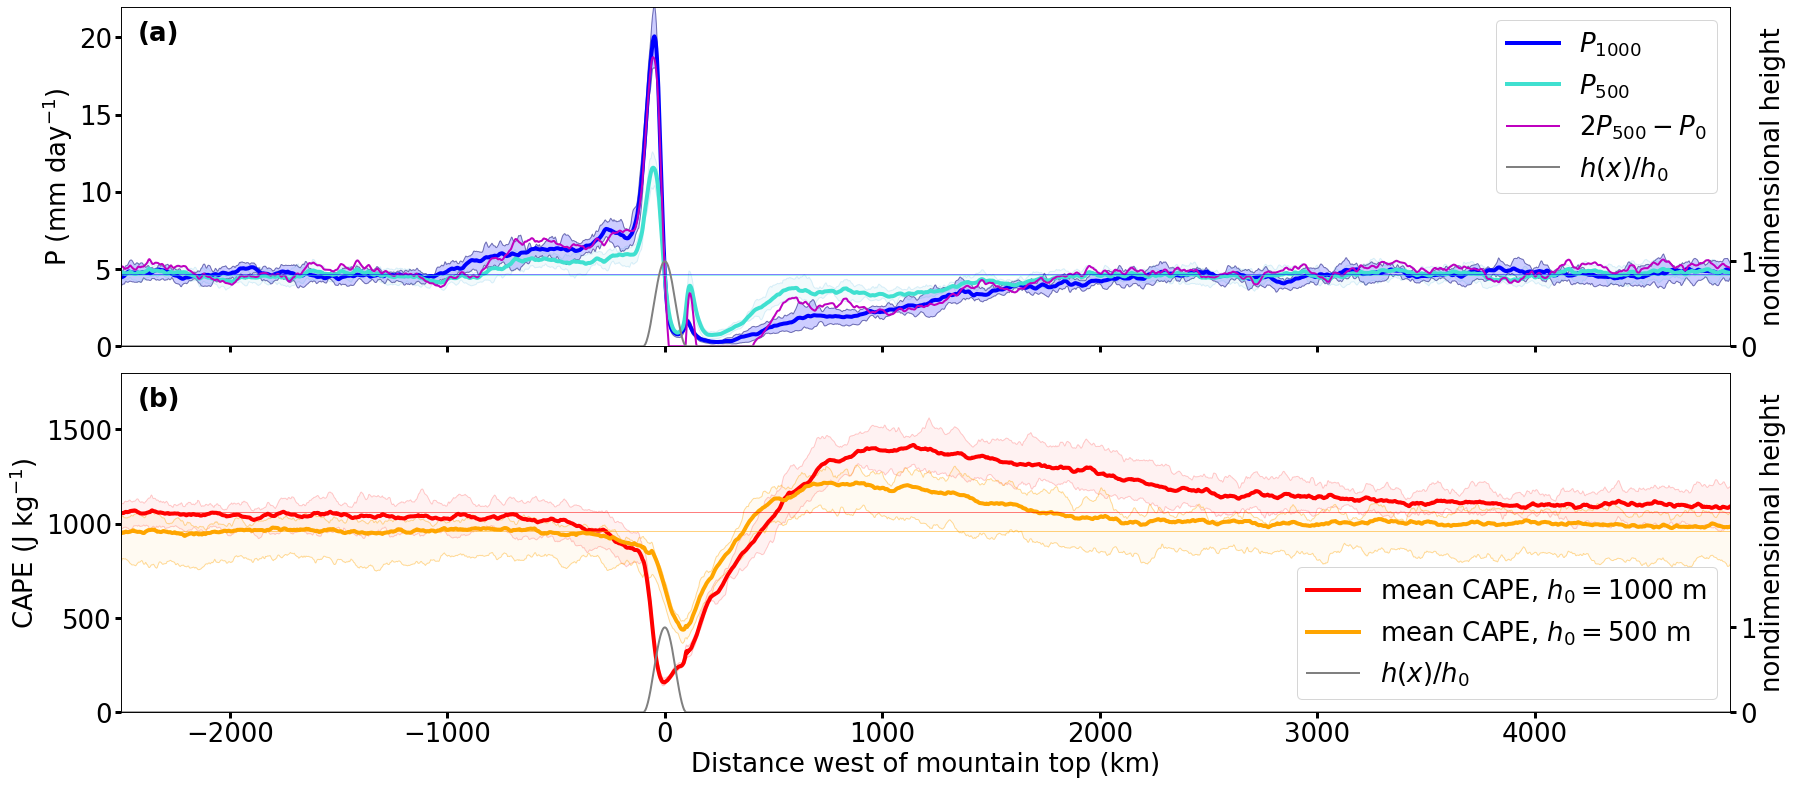

In [151]:
matplotlib.rcParams.update({'font.size': 26})

fig,(axpr,axca)=plt.subplots(2,1,figsize=(25,11))
axmt1=axpr.twinx()
axmt2=axca.twinx()

lw=2
lw2=4
falpha=0.1
ealpha=0.3

#PANEL 1 - Precip
#main precip curves
axpr.plot(hrdist,deeppr,label=r"$P_{1000}$",color='b',linewidth=lw2)
axpr.plot(hrdist,lmdeeppr,label=r"$P_{500}$",color='turquoise',linewidth=lw2)
axpr.plot(hrdist,np.maximum(0.,2*(lmdeeppr-4.4)+4.4),label=r"$2P_{500}-P_0$",color='m',linewidth=lw)

#shading
axpr.fill_between(hrdist,deeppr_percentiles.sel(percentile=25),deeppr_percentiles.sel(percentile=75),facecolor=(0,0,1,falpha), edgecolor=(0,0,1,ealpha))
axpr.fill_between(hrdist,lmdeeppr_percentiles.sel(percentile=25),lmdeeppr_percentiles.sel(percentile=75),facecolor=(*to_rgb('skyblue'),falpha), edgecolor=(*to_rgb('skyblue'),ealpha))

axpr.fill_between(hrdist,deeppr_percentiles.sel(percentile=25),deeppr_percentiles.sel(percentile=75),facecolor=(0,0,1,falpha), edgecolor=(0,0,0,ealpha))

#P_0
axpr.axhline(deeppr[2000:3000].mean(),color='b',linestyle='-',linewidth=.5)
axpr.axhline(lmdeeppr[2000:3000].mean(),color='turquoise',linestyle='-',linewidth=.5)

axpr.set_ylim(0,22)
axpr.set_ylabel(r'P (mm day$^{-1}$)')


#PANEL 2 - CAPE
# main CAPE curves
axca.plot(hrdist,deepcape,label=r"mean CAPE, $h_0=1000$ m",color='r',linewidth=lw2)
axca.plot(hrdist,lmdeepcape,label=r"mean CAPE, $h_0=500$ m",color='orange',linewidth=lw2)
#shading
falpha=0.05;ealpha=0.2
axca.fill_between(hrdist,deepcape_percentiles.sel(percentile=25),deepcape_percentiles.sel(percentile=75),facecolor=(1.,0,0,falpha), edgecolor=(1.,0,0,ealpha))
falpha=0.05;ealpha=0.4
axca.fill_between(hrdist,lmdeepcape_percentiles.sel(percentile=25),lmdeepcape_percentiles.sel(percentile=75),facecolor=(*to_rgb('orange'),falpha), edgecolor=(*to_rgb('orange'),ealpha))
#CAPE_0
axca.axhline(deepcape[2000:3000].mean(),color='r',linestyle='-',linewidth=0.5)
axca.axhline(lmdeepcape[2000:3000].mean(),color='orange',linestyle='-',linewidth=0.5)

axca.set_ylim(0,1800)
axca.set_xlabel("Distance west of mountain top (km)")
axca.set_ylabel(r"CAPE (J kg$^{-1}$)")

#Mountains & decoration
for a,am,loc,txt in ((axpr,axmt1,0,'(a)'),(axca,axmt2,4,'(b)')):
    am.plot(hrdist,hrhgt/1000,color='gray',label=r'$h(x)/h_0$',linewidth=2)
    am.set_xlim(-2500,4900)
    am.set_ylim(0,4)
    am.set_ylabel('nondimensional height')
    am.set_yticks([0,1])
    
    lines,labels = a.get_legend_handles_labels()
    lines2,labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=loc)
    a.text(0.01, 0.9,txt, transform=a.transAxes,color='k',weight='bold')

    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if txt!='(b)': # Get rid of x ticks on top panel
        ticks=range(-2000,5000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))

fig.tight_layout(pad=0.4)
fig.savefig('/global/homes/q/qnicolas/orographicConvectionTheory/figures_review/wrfPCape.png', dpi=300 ,bbox_inches='tight')

# Figure 4 - x-z cross sections of vertical motion, from moist & dry simulations

In [33]:
deepwmean_s = change_coords_eta(deepchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.W.days100-250.nc'),staggered=True)
deepwdrymean_s = change_coords_eta(drydeepchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.W.days50-100.nc'),staggered=True)

deepwmean_p = interp_eta_to_pressure(deepchannel,deepwmean_s,plevs=np.arange(25.,990.,20.),dsinput=deepinput)
deepwdrymean_p = interp_eta_to_pressure(drydeepchannel,deepwdrymean_s,plevs=np.arange(25.,990.,20.),dsinput=deepinput)



In [34]:
deepwmean_p   .to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.W.days50-200.mean.nc")     
deepwdrymean_p.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.dry.3km.W.days50-100.mean.nc") 

In [31]:
wmean_p    = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.W.days50-200.mean.nc")     # control simulation
wdrymean_p = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.dry.3km.W.days50-100.mean.nc") # Lv=0 simulation

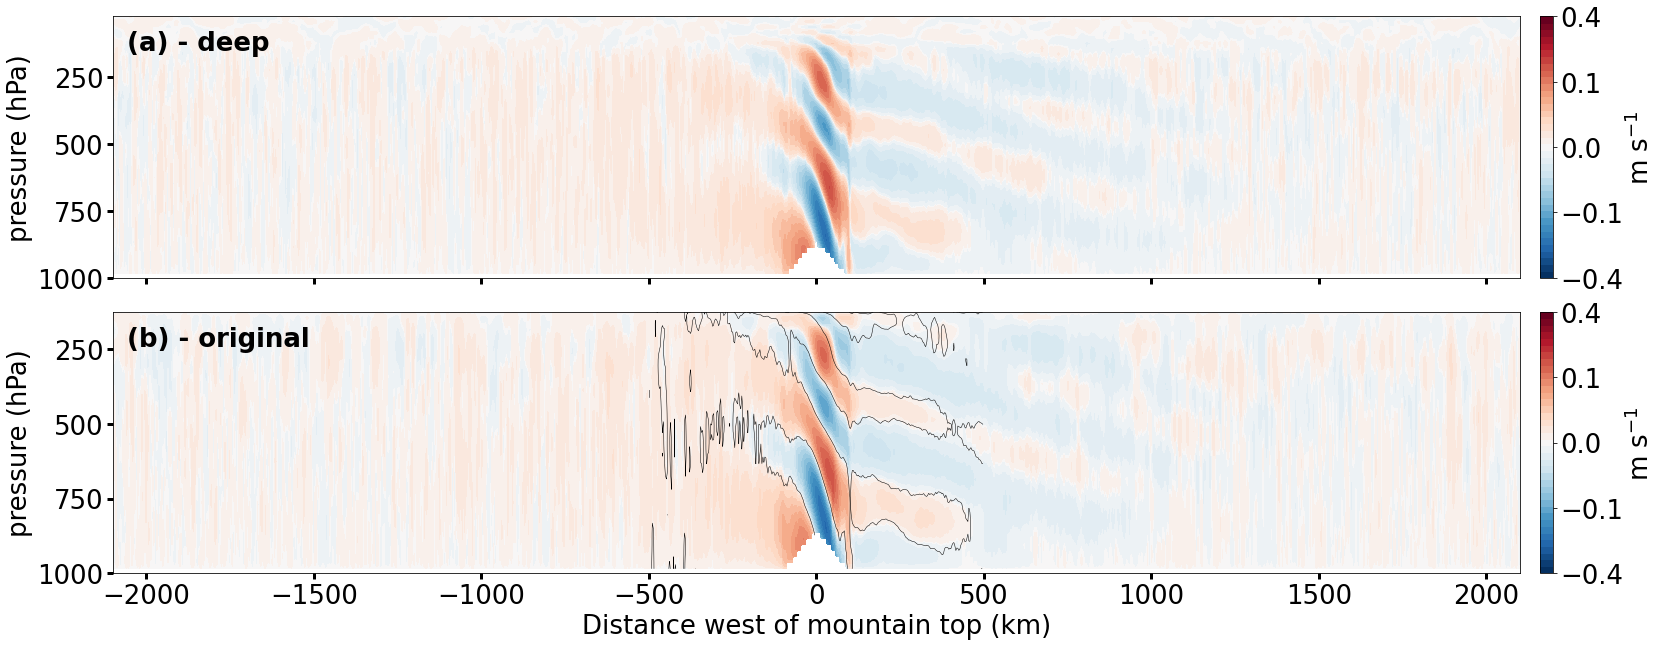

In [40]:
matplotlib.rcParams.update({'font.size': 26})
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

fig,ax=plt.subplots(2,1,figsize=(25,9))
wlevs=levs(0.4,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

deepwmean_p.plot.contourf(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})#,cmap=plt.cm.RdBu)
wmean_p.plot.contourf(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})

deepwmean_p.sel(distance_from_mtn=slice(500,-500),pressure=slice(1000,125)).plot.contour(ax=ax[1],yincrease=False, levels=[0.],colors=['k'],linewidths=[0.5])


for a in ax:
    a.set_ylabel("pressure (hPa)")
    a.set_xlim(-2100,2100)
    a.set_yticks([250,500,750,1000])
    a.tick_params(width=3,length=6)
    
ticks=range(-2000,2100,500)
ax[0].set_xticks(ticks)
ax[0].set_xticklabels([""]*len(ticks))
ax[0].set_xlabel("")
ax[1].set_xlabel("Distance west of mountain top (km)")

ax[0].text(0.01, 0.87,'(a) - deep', transform=ax[0].transAxes,color='k',weight='bold')
ax[1].text(0.01, 0.87,'(b) - original', transform=ax[1].transAxes,color='k',weight='bold')

fig.tight_layout(pad=0.3)

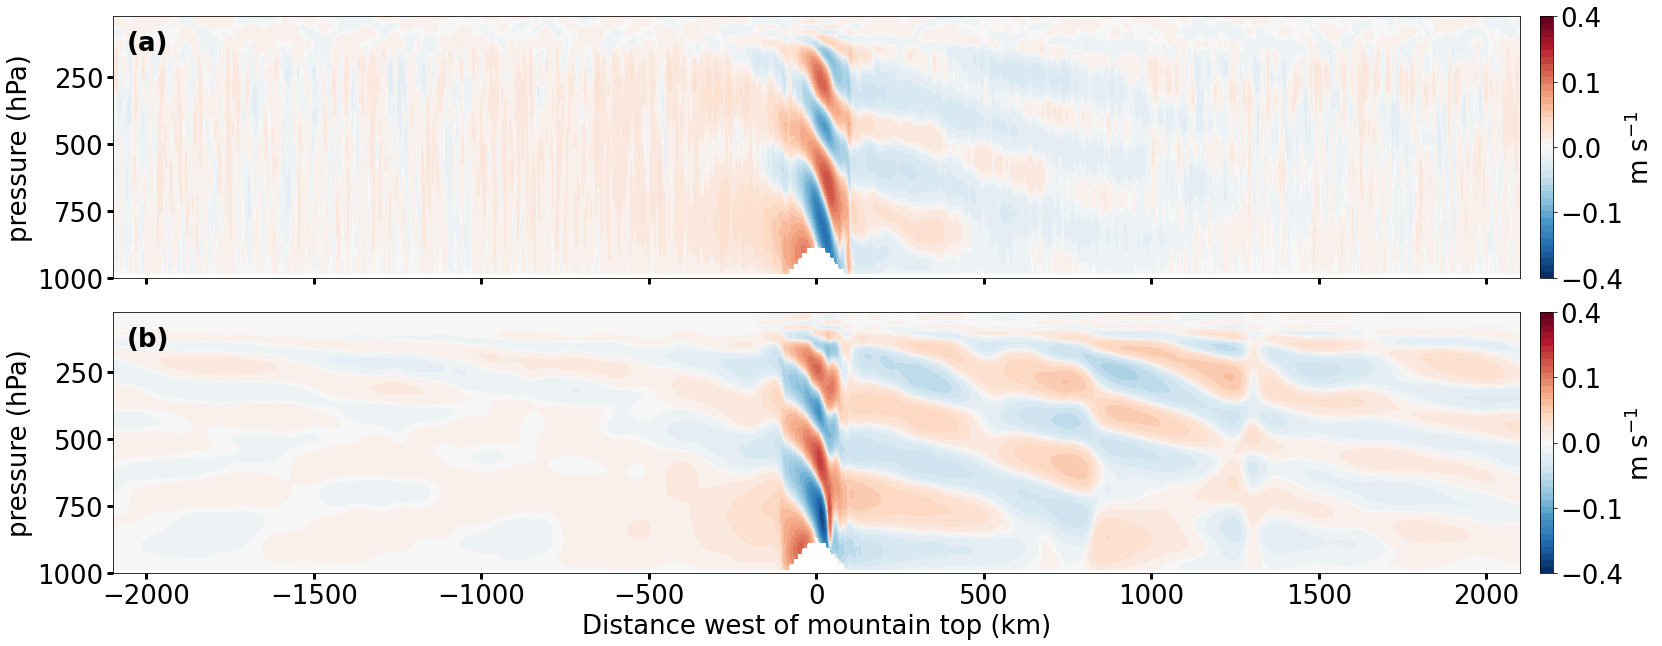

In [110]:
matplotlib.rcParams.update({'font.size': 26})
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

fig,ax=plt.subplots(2,1,figsize=(25,9))
wlevs=levs(0.4,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

deepwmean_p.plot.contourf(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})#,cmap=plt.cm.RdBu)
deepwdrymean_p.plot.contourf(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})

for a in ax:
    a.set_ylabel("pressure (hPa)")
    a.set_xlim(-2100,2100)
    a.set_yticks([250,500,750,1000])
    a.tick_params(width=3,length=6)
    
ticks=range(-2000,2100,500)
ax[0].set_xticks(ticks)
ax[0].set_xticklabels([""]*len(ticks))
ax[0].set_xlabel("")
ax[1].set_xlabel("Distance west of mountain top (km)")

ax[0].text(0.01, 0.87,'(a)', transform=ax[0].transAxes,color='k',weight='bold')
ax[1].text(0.01, 0.87,'(b)', transform=ax[1].transAxes,color='k',weight='bold')

fig.tight_layout(pad=0.3)
fig.savefig('/global/u2/q/qnicolas/orographicConvectionTheory/figures_review/wxz.png', dpi=300 ,bbox_inches='tight')


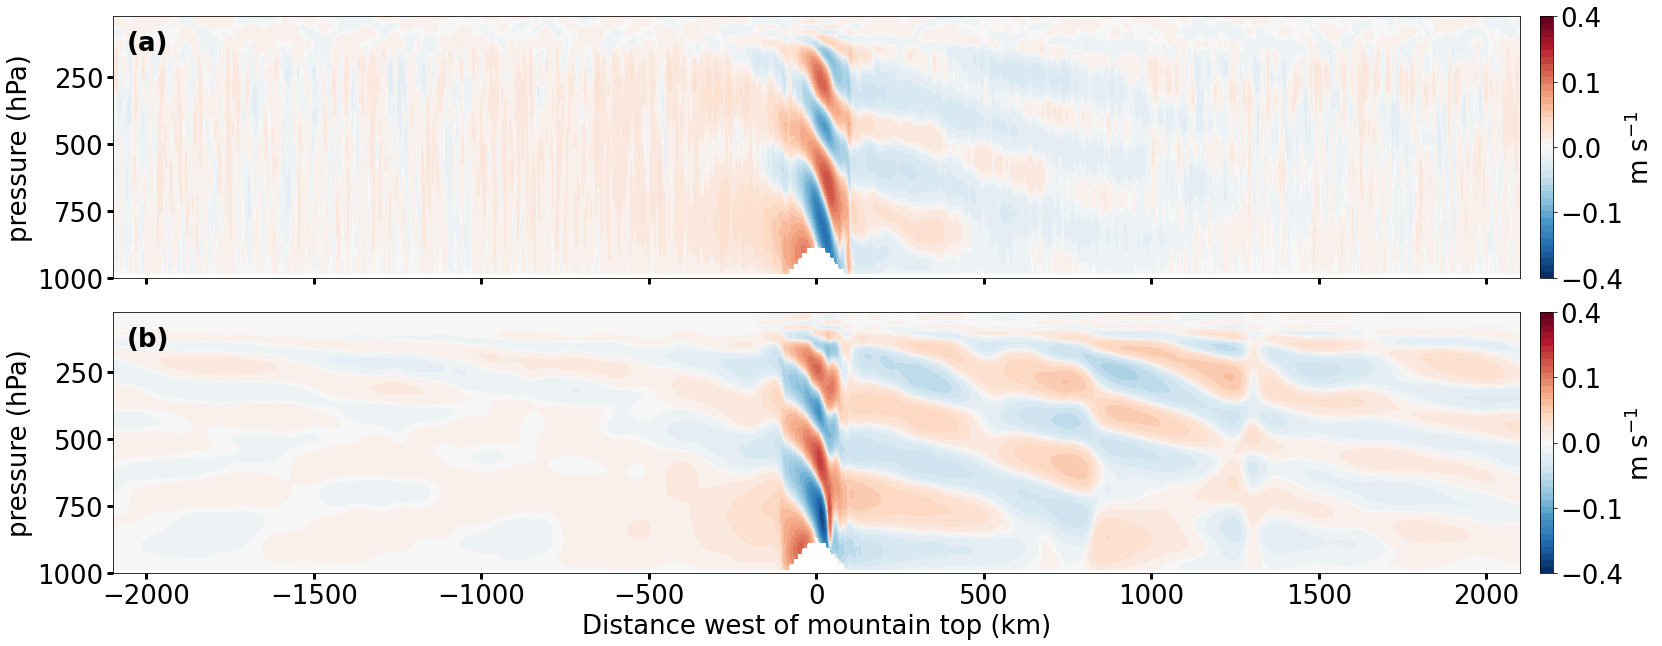

In [43]:
matplotlib.rcParams.update({'font.size': 26})
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

fig,ax=plt.subplots(2,1,figsize=(25,9))
wlevs=levs(0.4,2)
wticks=[-.5,-.4,-.1,0.,.1,.4,.5]

deepwmean_p.plot.contourf(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})#,cmap=plt.cm.RdBu)
deepwdrymean_p.plot.contourf(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':r'm s$^{-1}$','pad':.012})

for a in ax:
    a.set_ylabel("pressure (hPa)")
    a.set_xlim(-2100,2100)
    a.set_yticks([250,500,750,1000])
    a.tick_params(width=3,length=6)
    
ticks=range(-2000,2100,500)
ax[0].set_xticks(ticks)
ax[0].set_xticklabels([""]*len(ticks))
ax[0].set_xlabel("")
ax[1].set_xlabel("Distance west of mountain top (km)")

ax[0].text(0.01, 0.87,'(a)', transform=ax[0].transAxes,color='k',weight='bold')
ax[1].text(0.01, 0.87,'(b)', transform=ax[1].transAxes,color='k',weight='bold')

fig.tight_layout(pad=0.3)
fig.savefig('/global/u2/q/qnicolas/orographicConvectionTheory/figures_review/wxz.png', dpi=300 ,bbox_inches='tight')


# Figure 5 - x-y cross section of vertical motion at 500hPa

In [213]:
#%%time
#def change_coords_sn(var):
#    return var.assign_coords({'distance_ns':3*var.south_north}).swap_dims({'south_north':'distance_ns'})
#
#ndays=1
#w_day152 = change_coords_sn(change_coords_pl(hrchannel_p,hrchannel_p.W_PL.isel(Time=slice(3648,3648+ndays*24)).squeeze())).sel(distance_from_mtn=slice(400,-400))
#w_day152=w_day152.where(w_day152>-100).fillna(0.)
#w_day152=w_day152.sel(pressure=500.).persist()
#w_day152.to_netcdf("/global/cscratch1/sd/qnicolas/temp/wrf.W.day152.500hPa.nc")

CPU times: user 0 ns, sys: 11min 22s, total: 11min 22s
Wall time: 12min 50s


In [81]:
%%time
def change_coords_sn(var):
    return var.assign_coords({'distance_ns':3*var.south_north}).swap_dims({'south_north':'distance_ns'})

ndays=1
w_day152 = change_coords_sn(change_coords_pl(deepchannel_p,deepchannel_p.W_PL.isel(Time=187*24).squeeze())).sel(distance_from_mtn=slice(400,-400))
w_day152=w_day152.where(w_day152>-100).fillna(0.)
w_day152=w_day152.sel(pressure=500.).persist()
#w_day152.to_netcdf("/global/cscratch1/sd/qnicolas/temp/wrf.W.day152.500hPa.nc")

CPU times: user 50.1 ms, sys: 101 ms, total: 151 ms
Wall time: 228 ms


In [38]:
w_day152 = change_coords_sn(change_coords_pl(deepchannel_p,deepchannel_p.W_PL.isel(Time=188*24+4).squeeze())).sel(distance_from_mtn=slice(400,-400))
w_day152=w_day152.where(w_day152>-100).fillna(0.)
w_day152=w_day152.sel(pressure=500.).persist()

w_day152.to_netcdf("/global/u2/q/qnicolas/orographicConvectionTheory/data_review/wrf.W.day138.500hPa.nc")

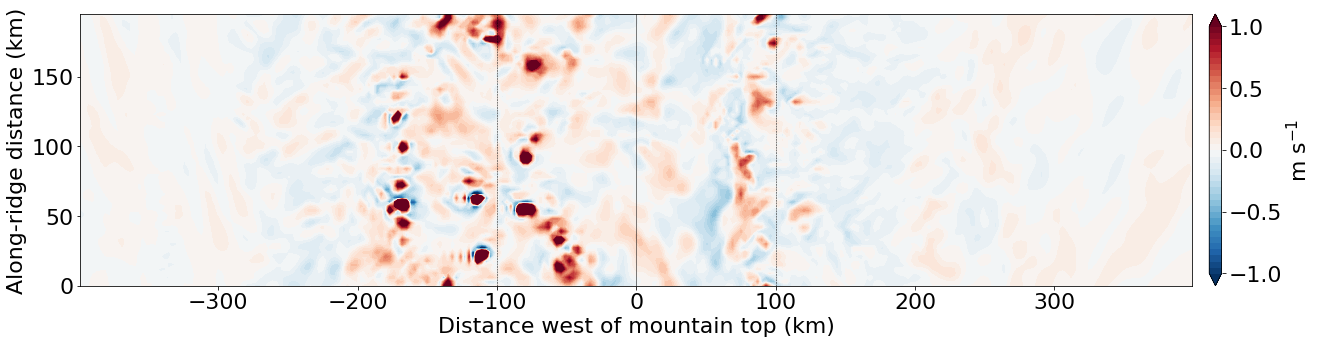

In [107]:
w_day152 = change_coords_sn(change_coords_pl(deepchannel_p,deepchannel_p.W_PL.isel(Time=188*24+4).squeeze())).sel(distance_from_mtn=slice(400,-400))
w_day152=w_day152.where(w_day152>-100).fillna(0.)
w_day152=w_day152.sel(pressure=500.).persist()

matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(1,1,figsize=(25,5))

wscale=1.
wlevs=np.linspace(-wscale,wscale,41)
wticks=np.arange(-1.5,1.6,0.5)
i=19

ax.axvline(   0.,color='k',linewidth=0.5)
ax.axvline(-100.,color='k',linewidth=0.5,linestyle='--')
ax.axvline( 100.,color='k',linewidth=0.5,linestyle='--')
w_day152.plot.contourf(ax=ax,levels=wlevs,cbar_kwargs={'ticks':wticks,'label':r'm s$^{-1}$','pad':.012})
ax.set_aspect("equal")
ax.set_xlabel("Distance west of mountain top (km)")
ax.set_ylabel("Along-ridge distance (km)")
ax.set_title("")
fig.savefig('/global/u2/q/qnicolas/orographicConvectionTheory/figures_review/wxy.eps',bbox_inches='tight')

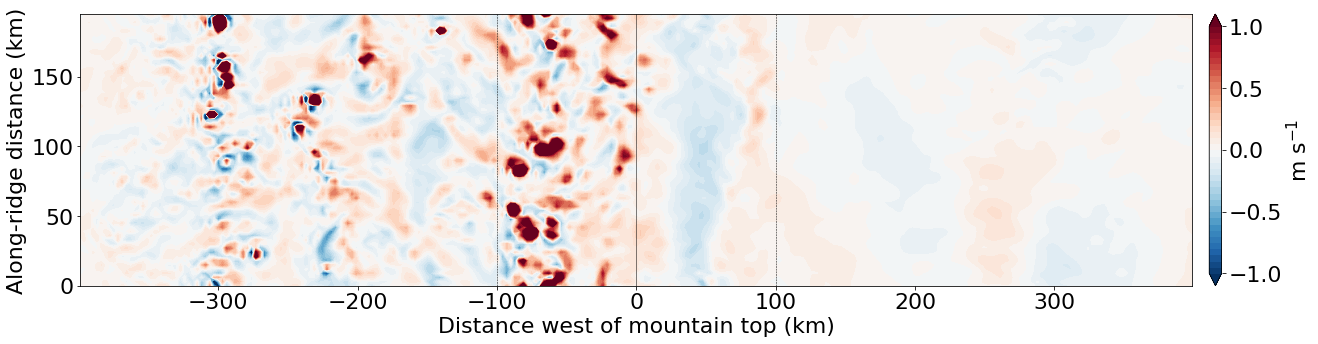

In [56]:
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(1,1,figsize=(25,5))

wscale=1.
wlevs=np.linspace(-wscale,wscale,41)
wticks=np.arange(-1.5,1.6,0.5)
i=19

ax.axvline(   0.,color='k',linewidth=0.5)
ax.axvline(-100.,color='k',linewidth=0.5,linestyle='--')
ax.axvline( 100.,color='k',linewidth=0.5,linestyle='--')
w_day152.isel(Time=i).plot.contourf(ax=ax,levels=wlevs,cbar_kwargs={'ticks':wticks,'label':r'm s$^{-1}$','pad':.012})
ax.set_aspect("equal")
ax.set_xlabel("Distance west of mountain top (km)")
ax.set_ylabel("Along-ridge distance (km)")
ax.set_title("")
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/wxy.eps',bbox_inches='tight')

# Figure 6 - Thermo equation breakdown

In [34]:
umean_p     = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.U_PL.days50-200.mean.nc")
tmean_p     = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")
omegamean_p = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.OMEGA_PL.days50-200.mean.nc")
thetamean_p = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.THETA_PL.days50-200.mean.nc")

dryumean_p     = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.dry.3km.U_PL.days50-200.mean.nc")
drytmean_p     = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.dry.3km.T_PL.days50-200.mean.nc")
dryomegamean_p = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.dry.3km.OMEGA_PL.days50-200.mean.nc")
drythetamean_p = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.dry.3km.THETA_PL.days50-200.mean.nc")

plevs_875 = np.array(umean_p.pressure[::-1])
DeltaP=250-875

Qrad = change_coords_sfc(-xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.radiativecooling.days50-200.mean.nc")/pT_ov_g/cp*86400)

pi = (drytmean_p.pressure/1e3)**0.286
dryudtdx = -(dryumean_p*drytmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
dryomegadsdp = (pi*dryomegamean_p*drythetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

udtdx = -(umean_p*tmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegadsdp = (pi*omegamean_p*thetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
Qdiab = udtdx+omegadsdp- Qrad

dryu0dtdx = -(-10*drytmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
dryomegads0dp = (pi*dryomegamean_p*drythetamean_p[:,2200:3000].mean('distance_from_mtn').differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

u0dtdx = -(-10*tmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegads0dp = (pi*omegamean_p*thetamean_p[:,2200:3000].mean('distance_from_mtn').differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
Qdiab_lin = u0dtdx+omegads0dp- Qrad

hrpr=xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
hrpr_K = Lc/cp/(-DeltaP*100)*g*hrpr

In [39]:
deepumean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.U_PL.days100-250.nc')
deepwmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.W_PL.days100-250.nc')
deeprhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.RHO_PL.days100-250.nc')
deeptmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.T_PL.days100-250.nc')

deepumean   = deepumean.where(deepumean >-30.)  
deepwmean   = deepwmean.where(deepwmean > -10)  
deeprhomean = deeprhomean.where(deeprhomean >0.)  
deeptmean   = deeptmean.where(deeptmean >100.)  
deepomegamean = -9.81*deeprhomean*deepwmean

deepumean_p =     change_coords_pl(deepchannel_p,deepumean)[5:-4]
deeptmean_p =     change_coords_pl(deepchannel_p,deeptmean)[5:-4]
deepomegamean_p = change_coords_pl(deepchannel_p,deepomegamean)[5:-4]
deepthetamean_p = (deeptmean_p*(deeptmean_p.pressure/1e3)**(-0.286))

drydeepumean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.U_PL.days50-100.nc')
drydeepwmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.W_PL.days50-100.nc')
drydeeprhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.RHO_PL.days50-100.nc')
drydeeptmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.T_PL.days50-100.nc')

drydeepumean   = drydeepumean.where(drydeepumean >-30.)  
drydeepwmean   = drydeepwmean.where(drydeepwmean > -10)  
drydeeprhomean = drydeeprhomean.where(drydeeprhomean >0.)  
drydeeptmean   = drydeeptmean.where(drydeeptmean >100.)   
drydeepomegamean = -9.81*drydeeprhomean*drydeepwmean

drydeepumean_p =     change_coords_sfc(drydeepumean)[5:-4]
drydeeptmean_p =     change_coords_sfc(drydeeptmean)[5:-4]
drydeepomegamean_p = change_coords_sfc(drydeepomegamean)[5:-4]
drydeepthetamean_p = (drydeeptmean_p*(drydeeptmean_p.pressure/1e3)**(-0.286))

In [41]:
#deepumean_p    .to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.U_PL.days50-200.mean.nc")
#deeptmean_p    .to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")
#deepomegamean_p.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.OMEGA_PL.days50-200.mean.nc")
#deepthetamean_p.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.THETA_PL.days50-200.mean.nc")
#
#drydeepumean_p    .to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.dry.3km.U_PL.days50-100.mean.nc")
#drydeeptmean_p    .to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.dry.3km.T_PL.days50-100.mean.nc")
#drydeepomegamean_p.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.dry.3km.OMEGA_PL.days50-100.mean.nc")
#drydeepthetamean_p.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.dry.3km.THETA_PL.days50-100.mean.nc")


In [45]:
plevs_875 = np.array(deepumean_p.pressure[::-1])
DeltaP=150-875

In [46]:
%%time
#deepQrad = deepchannel.RTHRATEN.sel(Time=slice(400,500)).mean(['Time','south_north'])*86400
deepQrad_p = interp_eta_to_pressure(deepchannel,change_coords_eta(deepchannel,deepQrad),staggered=0,plevs=plevs_875,dsinput=deepinput)
deepQrad = deepQrad_p.integrate('pressure')/DeltaP

CPU times: user 12.9 s, sys: 18.1 s, total: 31 s
Wall time: 29.4 s


In [51]:
#(-deepQrad).to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.radiativecooling.days50-200.mean.nc")

In [46]:
pi = (deepumean_p.pressure/1e3)**0.286
drydeepudtdx = -(drydeepumean_p*drydeeptmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
drydeepomegadsdp = (pi*drydeepomegamean_p*drydeepthetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

deepudtdx = -(deepumean_p*deeptmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
deepomegadsdp = (pi*deepomegamean_p*deepthetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
deepQdiab = deepudtdx+deepomegadsdp- deepQrad

In [47]:
drydeepu0dtdx = -(-10*drydeeptmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
drydeepomegads0dp = (pi*drydeepomegamean_p*drydeepthetamean_p[:,2200:3000].mean('distance_from_mtn').differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

deepu0dtdx = -(-10*deeptmean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
deepomegads0dp = (pi*deepomegamean_p*deepthetamean_p[:,2200:3000].mean('distance_from_mtn').differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
deepQdiab_lin = deepu0dtdx+deepomegads0dp- deepQrad

In [48]:
deeppr=deepchannelprecip.isel(Time=slice(400,1001)).mean(['Time','south_north']).load()
deeppr_K = 2.5e6/1004./(-DeltaP*100)*9.81*deeppr

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


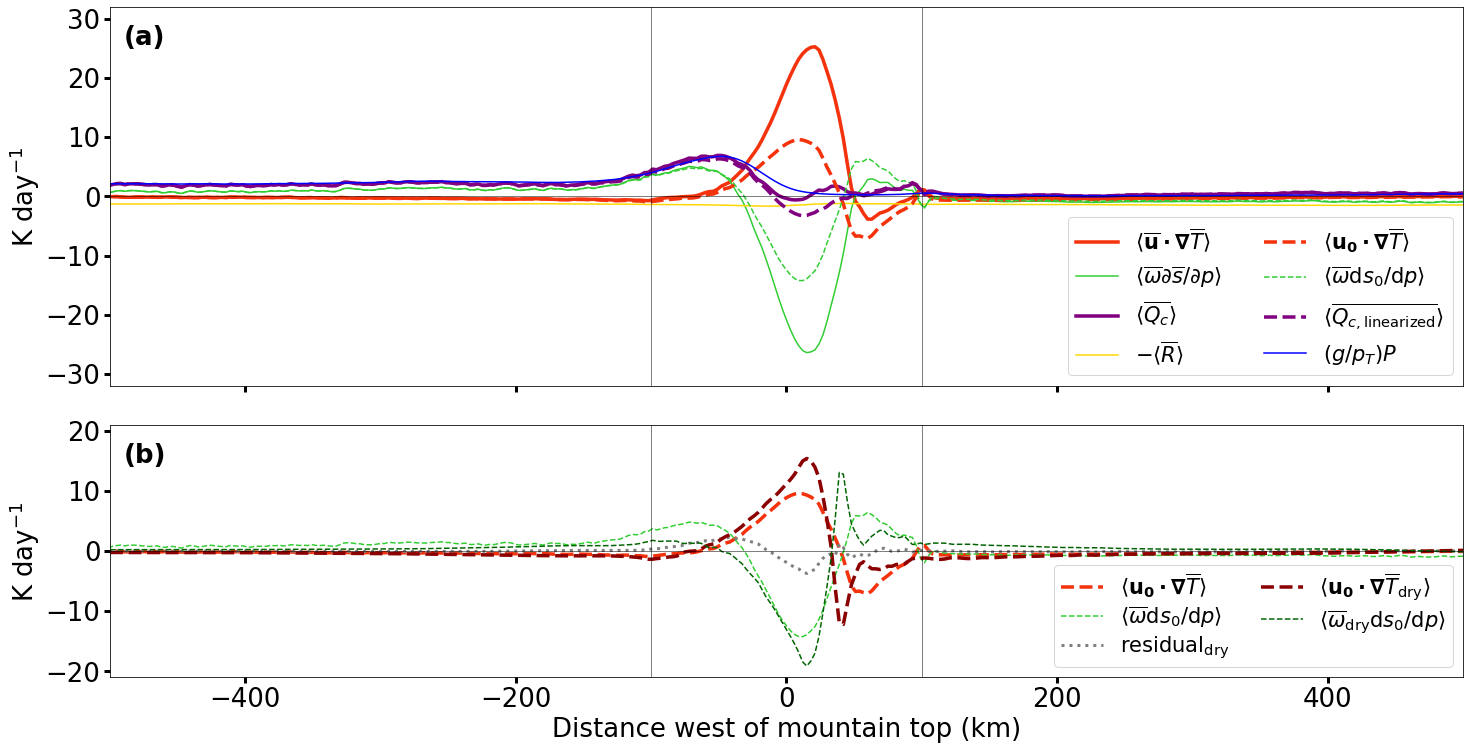

In [57]:
matplotlib.rcParams.update({'font.size': 26})

fig = plt.figure(figsize=(21,11))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3,2],figure=fig)
ax  = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
lw1=3.5
lw2=1.5

# First panel
ax.plot(hrdist, deepudtdx     ,linewidth=lw1,label=r"$\langle \mathbf{\overline{u} \cdot \nabla } \overline{T} \rangle$",color="xkcd:vermillion",linestyle='-')
ax.plot(hrdist, deepomegadsdp ,linewidth=lw2,label=r"$\langle \overline{\omega} \partial\overline{s}/\partial p\rangle$",color="limegreen"          ,linestyle='-')
ax.plot(hrdist, deepQdiab     ,linewidth=lw1,label=r"$\langle \overline{Q_c}                                   \rangle$", color="purple"        ,linestyle='-')
ax.plot(hrdist, deepQrad      ,linewidth=lw2,label=r"$-\langle \overline{R}                                    \rangle$", color='gold'        )

ax.plot(hrdist, deepu0dtdx    ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}     \rangle$",color="xkcd:vermillion",linestyle='--')
ax.plot(hrdist, deepomegads0dp,linewidth=lw2,label=r"$\langle\overline{\omega} \mathrm{d}s_0/\mathrm{d}p \rangle$",color="limegreen"      ,linestyle='--')
ax.plot(hrdist, deepQdiab_lin ,linewidth=lw1,label=r"$\langle\overline{Q_{c,\mathrm{linearized}}}        \rangle$",color="purple"         ,linestyle='--')
ax.plot(hrdist, deeppr_K      ,linewidth=lw2,label=r"$(g/p_T)P$", color='b')

# Second panel
ax2.plot(hrdist, deepu0dtdx      ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}    \rangle$",color="xkcd:vermillion",linestyle='--')
ax2.plot(hrdist, deepomegads0dp  ,linewidth=lw2,label=r"$\langle\overline{\omega} \mathrm{d}s_0/\mathrm{d}p\rangle$",color="limegreen"      ,linestyle='--')
ax2.plot(hrdist, drydeepu0dtdx +drydeepomegads0dp   ,linewidth=3,label=r"residual$_\mathrm{dry}$",color="grey" ,linestyle=':')

ax2.plot(hrdist, drydeepu0dtdx    ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}_\mathrm{dry}     \rangle$",color="darkred" ,linestyle='--')
ax2.plot(hrdist, drydeepomegads0dp,linewidth=lw2,label=r"$\langle\overline{\omega}_\mathrm{dry} \mathrm{d}s_0/\mathrm{d}p \rangle$",color="darkgreen"   ,linestyle='--')


#Decoration
for a in ax,ax2:
    a.axvline(-100.,color='k',linewidth=0.5)
    a.axvline(100.,color='k',linewidth=0.5)
    a.axhline(0.,color='k',linewidth=0.5)
    a.set_xlim(-500,500)
    a.set_ylabel(r"K day$^{-1}$")
    a.tick_params(width=3,length=6)
ax.legend(ncol=2,loc=4,fontsize=21)
ax2.legend(ncol=2,loc=4,fontsize=21,labelspacing=0.2,borderpad=0.3,columnspacing=1.5)
ax.set_ylim(-32,32)
ax2.set_ylim(-21,21)
ax2.set_xlabel("Distance west of mountain top (km)")
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.85,'(b)', transform=ax2.transAxes,color='k',weight='bold')

ticks=range(-400,500,200)
ax.set_xticks(ticks)
ax.set_xticklabels([""]*len(ticks))
ax2.set_yticks(range(-20,21,10))

fig.tight_layout()
fig.savefig('/global/u2/q/qnicolas/orographicConvectionTheory/figures_review/thermoeqn.eps',bbox_inches='tight')


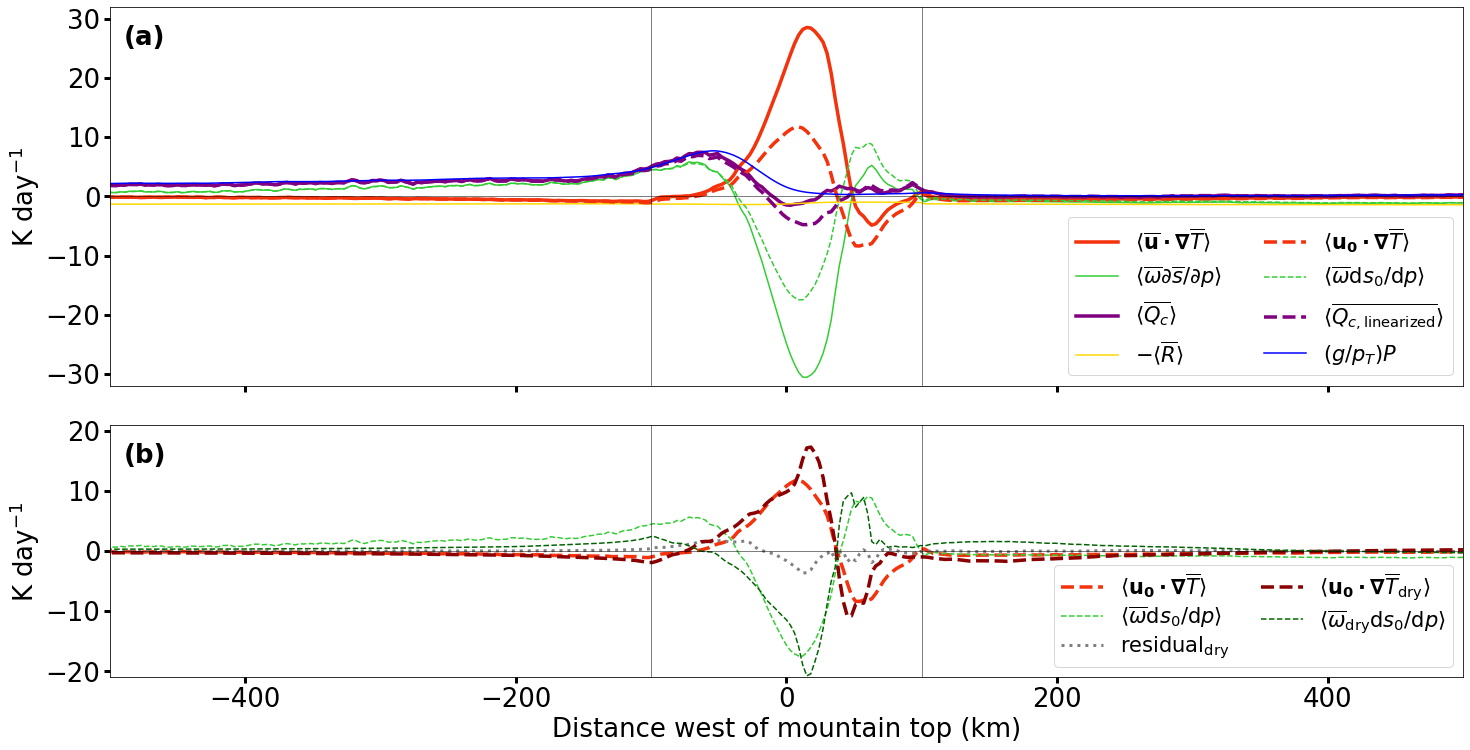

In [10]:
matplotlib.rcParams.update({'font.size': 26})

fig = plt.figure(figsize=(21,11))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3,2],figure=fig)
ax  = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
lw1=3.5
lw2=1.5

# First panel
ax.plot(hrdist, udtdx     ,linewidth=lw1,label=r"$\langle \mathbf{\overline{u} \cdot \nabla } \overline{T} \rangle$",color="xkcd:vermillion",linestyle='-')
ax.plot(hrdist, omegadsdp ,linewidth=lw2,label=r"$\langle \overline{\omega} \partial\overline{s}/\partial p\rangle$",color="limegreen"          ,linestyle='-')
ax.plot(hrdist, Qdiab     ,linewidth=lw1,label=r"$\langle \overline{Q_c}                                   \rangle$", color="purple"        ,linestyle='-')
ax.plot(hrdist, Qrad      ,linewidth=lw2,label=r"$-\langle \overline{R}                                    \rangle$", color='gold'        )

ax.plot(hrdist, u0dtdx    ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}     \rangle$",color="xkcd:vermillion",linestyle='--')
ax.plot(hrdist, omegads0dp,linewidth=lw2,label=r"$\langle\overline{\omega} \mathrm{d}s_0/\mathrm{d}p \rangle$",color="limegreen"      ,linestyle='--')
ax.plot(hrdist, Qdiab_lin ,linewidth=lw1,label=r"$\langle\overline{Q_{c,\mathrm{linearized}}}        \rangle$",color="purple"         ,linestyle='--')
ax.plot(hrdist, hrpr_K      ,linewidth=lw2,label=r"$(g/p_T)P$", color='b')

# Second panel
ax2.plot(hrdist, u0dtdx      ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}    \rangle$",color="xkcd:vermillion",linestyle='--')
ax2.plot(hrdist, omegads0dp  ,linewidth=lw2,label=r"$\langle\overline{\omega} \mathrm{d}s_0/\mathrm{d}p\rangle$",color="limegreen"      ,linestyle='--')
ax2.plot(hrdist, dryu0dtdx +dryomegads0dp   ,linewidth=3,label=r"residual$_\mathrm{dry}$",color="grey" ,linestyle=':')

ax2.plot(hrdist, dryu0dtdx    ,linewidth=lw1,label=r"$\langle\mathbf{u_0 \cdot \nabla } \overline{T}_\mathrm{dry}     \rangle$",color="darkred" ,linestyle='--')
ax2.plot(hrdist, dryomegads0dp,linewidth=lw2,label=r"$\langle\overline{\omega}_\mathrm{dry} \mathrm{d}s_0/\mathrm{d}p \rangle$",color="darkgreen"   ,linestyle='--')

#Decoration
for a in ax,ax2:
    a.axvline(-100.,color='k',linewidth=0.5)
    a.axvline(100.,color='k',linewidth=0.5)
    a.axhline(0.,color='k',linewidth=0.5)
    a.set_xlim(-500,500)
    a.set_ylabel(r"K day$^{-1}$")
    a.tick_params(width=3,length=6)
ax.legend(ncol=2,loc=4,fontsize=21)
ax2.legend(ncol=2,loc=4,fontsize=21,labelspacing=0.2,borderpad=0.3,columnspacing=1.5)
ax.set_ylim(-32,32)
ax2.set_ylim(-21,21)
ax2.set_xlabel("Distance west of mountain top (km)")
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.85,'(b)', transform=ax2.transAxes,color='k',weight='bold')

ticks=range(-400,500,200)
ax.set_xticks(ticks)
ax.set_xticklabels([""]*len(ticks))
ax2.set_yticks(range(-20,21,10))

fig.tight_layout()

In [34]:
deepomegadqsatdp = 2.5e6/1004.*(deepomegamean_p*qsat(deeptmean_p,deeptmean_p.pressure).differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

(-2.0, 10.0)

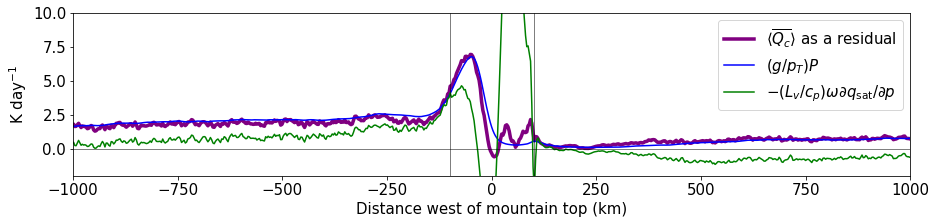

In [37]:
matplotlib.rcParams.update({'font.size': 15})

fig,ax = plt.subplots(1,1,figsize=(15,3))

# First panel
ax.plot(hrdist, deepQdiab     ,linewidth=lw1,label=r"$\langle \overline{Q_c}\rangle$ as a residual", color="purple"        ,linestyle='-')
ax.plot(hrdist, deeppr_K      ,linewidth=lw2,label=r"$(g/p_T)P$", color='b')
ax.plot(hrdist, -deepomegadqsatdp      ,linewidth=lw2,label=r"$-(L_v/c_p) \omega \partial q_{\mathrm{sat}}/\partial p$", color='g')


#Decoration
ax.axvline(-100.,color='k',linewidth=0.5)
ax.axvline(100.,color='k',linewidth=0.5)
ax.axhline(0.,color='k',linewidth=0.5)
ax.set_xlim(-1000,1000)
ax.set_ylabel(r"K day$^{-1}$")
ax.set_xlabel("Distance west of mountain top (km)")
ax.legend()
ax.set_ylim(-2,10)


# Figure 7 - $\hat T_d$ and $\hat q_d$

In [11]:
tmean_p    = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")
drytmean_p = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.dry.3km.T_PL.days50-200.mean.nc")
qmean_p    = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.Q_PL.days50-200.mean.nc")
dryqmean_p = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.dry.3km.Q_PL.days50-200.mean.nc")

In [12]:
tmean_p_hat_prime         = hatprime(tmean_p,0,7)
drytmean_p_hat_prime      = hatprime(drytmean_p,0,7)

qmean_p_hat_prime         = Lc/cp*hatprime(qmean_p,0,7)    # convert to K
dryqmean_p_hat_prime      = Lc/cp*hatprime(dryqmean_p,0,7) # convert to K

xx,hx = topographic_profile(kind='cos',a=100e3,A=1000)
Td_hat_linear,qd_hat_linear = linear_TdL_qdL(xx,hx,10)  #Predictions of the linear theory; see orographicConvectionTheory.py

In [52]:
deeptmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.T_PL.days100-250.nc')
deeptmean   = deeptmean.where(deeptmean >100.)  
deeptmean_p = change_coords_pl(deepchannel_p,deeptmean)[5:-4]

deepqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.Q_PL.days100-250.nc')
deepqmean   = deepqmean.where(deepqmean >0.)  
deepqmean_p = change_coords_pl(deepchannel_p,deepqmean)[5:-4]

deeptmean_p_hat_prime         = hatprime(deeptmean_p,0,7)
deepqmean_p_hat_prime         = Lc/cp*hatprime(deepqmean_p,0,7)    # convert to K

In [53]:
drydeeptmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.T_PL.days50-100.nc')
drydeeptmean   = drydeeptmean.where(drydeeptmean >100.)
drydeeptmean_p = change_coords_sfc(drydeeptmean)[5:-4]

drydeepqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.Q_PL.days50-100.nc')
drydeepqmean   = drydeepqmean.where(drydeepqmean >0.)
drydeepqmean_p = change_coords_sfc(drydeepqmean)[5:-4]

drydeeptmean_p_hat_prime         = hatprime(drydeeptmean_p,0,7)
drydeepqmean_p_hat_prime         = Lc/cp*hatprime(drydeepqmean_p,0,7)    # convert to K

In [55]:
#deepqmean_p.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.Q_PL.days50-200.mean.nc")
#drydeepqmean_p.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.dry.3km.Q_PL.days50-100.mean.nc")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


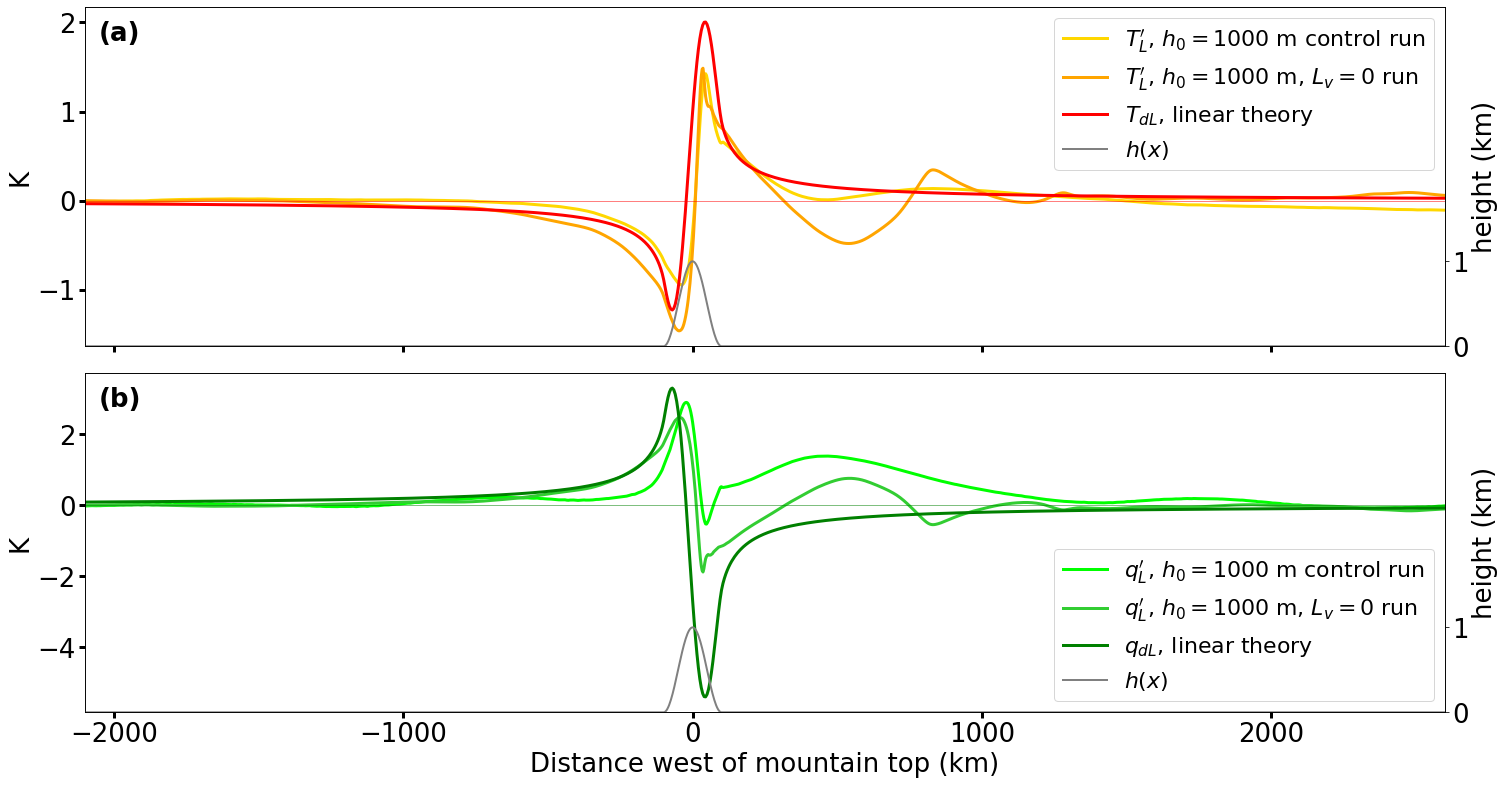

In [19]:
matplotlib.rcParams.update({'font.size': 26})
fig,(ax,ax2) = plt.subplots(2,1,figsize=(21,11))
axm=ax.twinx()
ax2m=ax2.twinx()

# Panel a : temperature deviations
deeptmean_p_hat_prime.plot(   ax=ax,color='gold'  ,linewidth=3,label=r"$T_L'$, $h_0=1000$ m control run")
drydeeptmean_p_hat_prime.plot(ax=ax,color='orange',linewidth=3,label=r"$T_L'$, $h_0=1000$ m, $L_v=0$ run")
ax.plot(xx/1000,Td_hat_linear,   color='red'   ,linewidth=3,label=r"$T_{dL}$, linear theory")
ax.axhline(0.,linestyle='-',linewidth='0.5',color='red')

# Panel b : moisture deviations
deepqmean_p_hat_prime.plot(   ax=ax2,color='lime'     ,linewidth=3,label=r"$q_L'$, $h_0=1000$ m control run")
drydeepqmean_p_hat_prime.plot(ax=ax2,color='limegreen',linewidth=3,label=r"$q_L'$, $h_0=1000$ m, $L_v=0$ run")
ax2.plot(xx/1000,qd_hat_linear,   color='green'    ,linewidth=3,label=r"$q_{dL}$, linear theory")
ax2.axhline(0.,linestyle='-',linewidth='0.5',color='green')


for a,am in (ax,axm),(ax2,ax2m):
    a.set_xlim(-2100,2600)
    a.set_ylabel("K")
    a.legend(fontsize=20)
    
    am.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    a.tick_params(width=3,length=6)
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2,fontsize=22)
ax2.legend(lines + lines2, labels + labels2,fontsize=22,loc=4)
 
ticks=range(-2000,3000,1000)
ax.set_xticks(ticks)
ax.set_xticklabels([""]*len(ticks))

ax.set_xlabel('')
ax2.set_xlabel('Distance west of mountain top (km)')
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.9,'(b)', transform=ax2.transAxes,color='k',weight='bold')
fig.tight_layout(pad=0.4)
fig.savefig('/global/homes/q/qnicolas/orographicConvectionTheory/figures_review/TLqL.eps',bbox_inches='tight')

# Figure 8 - Unfitted and fitted precip

In [18]:
tmean_p    = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")
lmtmean_p  = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.500m.3km.T_PL.days50-200.mean.nc")
dryqmean_p = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.dry.3km.Q_PL.days50-200.mean.nc")
tmean_p_hat_prime         = hatprime(tmean_p,0,7)
lmtmean_p_hat_prime = hatprime(lmtmean_p,0,7)
dryqmean_p_hat_prime      = Lc/cp*hatprime(dryqmean_p,0,7) # convert to K


In [19]:
%%time
hrpr=xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
lmpr=xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.500m.3km.precip.days50-200.mean.nc")

xx,hx = topographic_profile(kind='cos',a=100e3,A=1000)
Plin        = linear_precip_theory(xx,hx,  10)
Plin_fit    = linear_precip_theory(xx,hx,  10,tauT=7.5,tauq=27.5)
Plin500_fit = linear_precip_theory(xx,hx/2,10,tauT=7.5,tauq=27.5)

Pnonlin       = nonlinear_precip_theory(1000*hrdist[::-1],np.array(tmean_p_hat_prime)[::-1],np.array(dryqmean_p_hat_prime)[::-1],10)[::-1] #wrf data are sorted west to east, we need to flip them before inputting to the nonlinear precip theory
Pnonlin_fit   = nonlinear_precip_theory(1000*hrdist[::-1],np.array(tmean_p_hat_prime)[::-1],np.array(dryqmean_p_hat_prime)[::-1],10,tauT=7.5,tauq=27.5)[::-1] 
lmPnonlin_fit = nonlinear_precip_theory(1000*hrdist[::-1],np.array(lmtmean_p_hat_prime)[::-1],np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5)[::-1] 

CPU times: user 13.6 s, sys: 0 ns, total: 13.6 s
Wall time: 13.6 s


In [10]:
import sys; import os
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)
from tools.generalTools import qsat,humidsat

def HwCw(temp_surface,ps,gamma,gamma_m):
    """Compute water vapor scale height and coefficient Cw assuming a moist adiabatic atmosphere
     - temp_surface = surface temperature (np.array)
     - ps = surface pressure (np.array)
     - gamma = environment lapse rate
    """
    L=2.5e6
    Hw = 461.*temp_surface**2/(L*gamma)
    Cw = humidsat(temp_surface,ps/100)[0]*100/287./temp_surface*gamma_m/gamma
    return Hw,Cw
def smith_theory(u,gamma,gamma_m,ts=300.,tau=2000,kind='gaussian'):
    ps=100000.
    Hw,Cw = HwCw(ts,ps,gamma,gamma_m)
    if gamma < gamma_m:
        N=np.sqrt(9.81/ts*(gamma_m-gamma))
        print("using moist stability, N=%.3f"%N)
    else:
        N=np.sqrt(9.81/ts*(9.81/1000-gamma))
        print("using dry stability, N=%.3f"%N)
    print("Hw=%i,Cw=%.3f"%(Hw,Cw))

    tau_c=tau
    tau_f=tau
    P0=4.5 #mm/day
    
    xx=np.arange(-10000e3,10000e3,1e3)
    A = 1000
    a = 100e3
    if kind=='gaussian':
        hx = A*np.exp(-xx**2/2/(a/2)**2)
    elif kind=='cos':
        hx = A/2*(1+np.cos(np.pi*np.maximum(-1,np.minimum(1,xx/a))))
    k=k_vector(len(xx),xx[1]-xx[0])
    
    P=np.maximum(P0+86400*np.real(np.fft.ifft(Cw*np.fft.fft(hx)*1j*u*k/(1-Hw*m_exponent(k,N,u))/(1+1j*u*k*tau_c)/(1+1j*u*k*tau_f))),0.)
    return xx,hx,P

In [11]:
xx2,_,Plin_smith = smith_theory(10,5e-3,4.32e-3,kind='cos')

using dry stability, N=0.013
Hw=3319,Cw=0.036


Text(0.01, 0.9, '(c)')

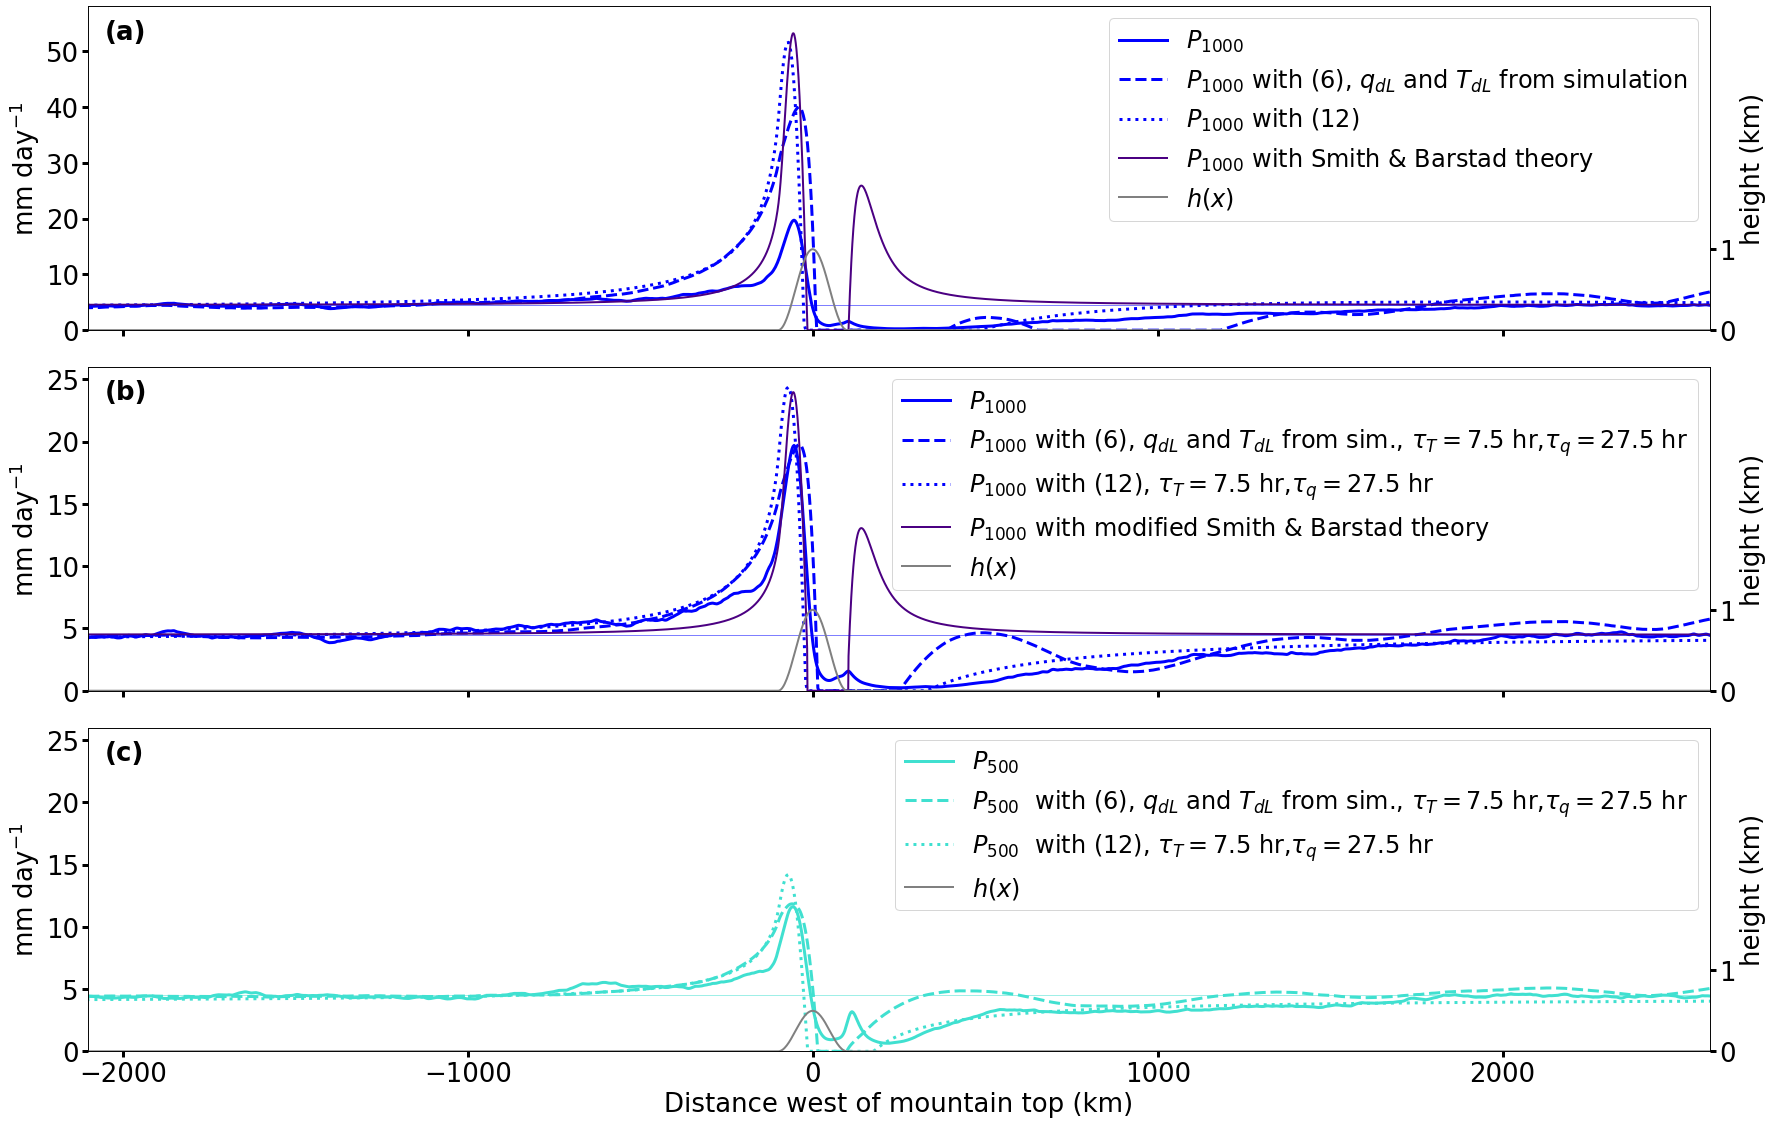

In [ ]:
matplotlib.rcParams.update({'font.size': 26})
fig,(ax,ax2,ax3)=plt.subplots(3,1,figsize=(25,16))
axm=ax.twinx()
axm2=ax2.twinx()
axm3=ax3.twinx()

lw=3

# Top panel
ax.plot(hrdist,hrpr,    label=r"$P_{1000}$",color='b',linewidth=lw)
ax.plot(hrdist,Pnonlin, label=r"$P_{1000}$ with (6), $q_{dL}$ and $T_{dL}$ from simulation",color='b',linestyle='--',linewidth=lw)
ax.plot(xx/1000,Plin,    label=r"$P_{1000}$ with (12)",color='b',linestyle=':',linewidth=lw)
ax.plot(xx2/1000,Plin_smith,    label=r"$P_{1000}$ with Smith & Barstad theory",color='indigo',linestyle='-',linewidth=2)

## Middle panel
ax2.plot(hrdist,hrpr,        label=r"$P_{1000}$",color='b',linewidth=lw)
ax2.plot(hrdist,Pnonlin_fit, label=r"$P_{1000}$ with (6), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle='--',linewidth=lw)
ax2.plot(xx/1000,Plin_fit,    label=r"$P_{1000}$ with (12), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle=':',linewidth=lw)
ax2.plot(xx2/1000,((Plin_smith-4.5)/2.5+4.5)*(Plin_smith>0),    label=r"$P_{1000}$ with modified Smith & Barstad theory",color='indigo',linestyle='-',linewidth=2)

## Bottom panel
ax3.plot(hrdist,lmpr,          label=r"$P_{500}$",color='turquoise',linewidth=lw)
ax3.plot(hrdist,lmPnonlin_fit, label=r"$P_{500}$  with (6), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle='--',linewidth=lw)
ax3.plot(xx/1000,Plin500_fit,   label=r"$P_{500}$  with (12), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle=':',linewidth=lw)


ax.set_ylim(0,58)
ax2.set_ylim(0,26)
ax3.set_ylim(0,26)

for i,(a,am) in enumerate(zip((ax,ax2,ax3),(axm,axm2,axm3))):
    a.set_ylabel(r'mm day$^{-1}$')
    a.set_xlim(-2.1e3,2.6e3)
    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if i==2:
        a.set_xlabel('Distance west of mountain top (km)')
        a.axhline(4.5,linestyle='-',linewidth=0.5,color='turquoise')
        am.plot(hrdist,hrhgt/1000/2,label=r"$h(x)$",color='gray',linewidth=2)
    else:
        ticks=range(-2000,3000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))
        a.axhline(4.5,linestyle='-',linewidth=0.5,color='b')
        am.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)
    
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=1,fontsize=24)
fig.tight_layout(pad=0.8)
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.9,'(b)', transform=ax2.transAxes,color='k',weight='bold')
ax3.text(0.01, 0.9,'(c)', transform=ax3.transAxes,color='k',weight='bold')

In [22]:
deeptmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.T_PL.days100-250.nc')
deeptmean   = deeptmean.where(deeptmean >100.)  
deeptmean_p = change_coords_pl(deepchannel_p,deeptmean)[5:-4]

lmdeeptmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.T_PL.days50-200.nc')
lmdeeptmean   = lmdeeptmean.where(lmdeeptmean >100.)  
lmdeeptmean_p = change_coords_pl(lmdeepchannel_p,lmdeeptmean)[5:-4]

drydeepqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/wrf.Q_PL.days50-100.nc')
drydeepqmean   = drydeepqmean.where(drydeepqmean >0.)  
drydeepqmean_p = change_coords_sfc(drydeepqmean)[5:-4]


deeptmean_p_hat_prime   = hatprime(deeptmean_p,0,7)
lmdeeptmean_p_hat_prime = hatprime(lmdeeptmean_p,0,7)
drydeepqmean_p_hat_prime      = Lc/cp*hatprime(drydeepqmean_p,0,7) # convert to K



In [10]:
#lmdeeptmean_p.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.500m.3km.T_PL.days50-200.mean.nc")


In [13]:
%%time
deeppr  =deepchannelprecip.isel(Time=slice(400,1001)).mean(['Time','south_north']).load()
lmdeeppr=lmdeepchannelprecip.isel(Time=slice(200,801)).mean(['Time','south_north']).load()

xx,hx = topographic_profile(kind='cos',a=100e3,A=1000)
Plin        = linear_precip_theory(xx,hx,  10)
Plin_fit    = linear_precip_theory(xx,hx,  10,tauT=7.5,tauq=27.5)
Plin500_fit = linear_precip_theory(xx,hx/2,10,tauT=7.5,tauq=27.5)

deepPnonlin       = nonlinear_precip_theory(1000*hrdist[::-1],np.array(deeptmean_p_hat_prime)[::-1],np.array(drydeepqmean_p_hat_prime)[::-1],10)[::-1] #wrf data are sorted west to east, we need to flip them before inputting to the nonlinear precip theory
deepPnonlin_fit   = nonlinear_precip_theory(1000*hrdist[::-1],np.array(deeptmean_p_hat_prime)[::-1],np.array(drydeepqmean_p_hat_prime)[::-1],10,tauT=7.5,tauq=27.5)[::-1] 
lmdeepPnonlin_fit = nonlinear_precip_theory(1000*hrdist[::-1],np.array(lmdeeptmean_p_hat_prime)[::-1],np.array(drydeepqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5)[::-1] 

CPU times: user 13.5 s, sys: 2 s, total: 15.5 s
Wall time: 15.7 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


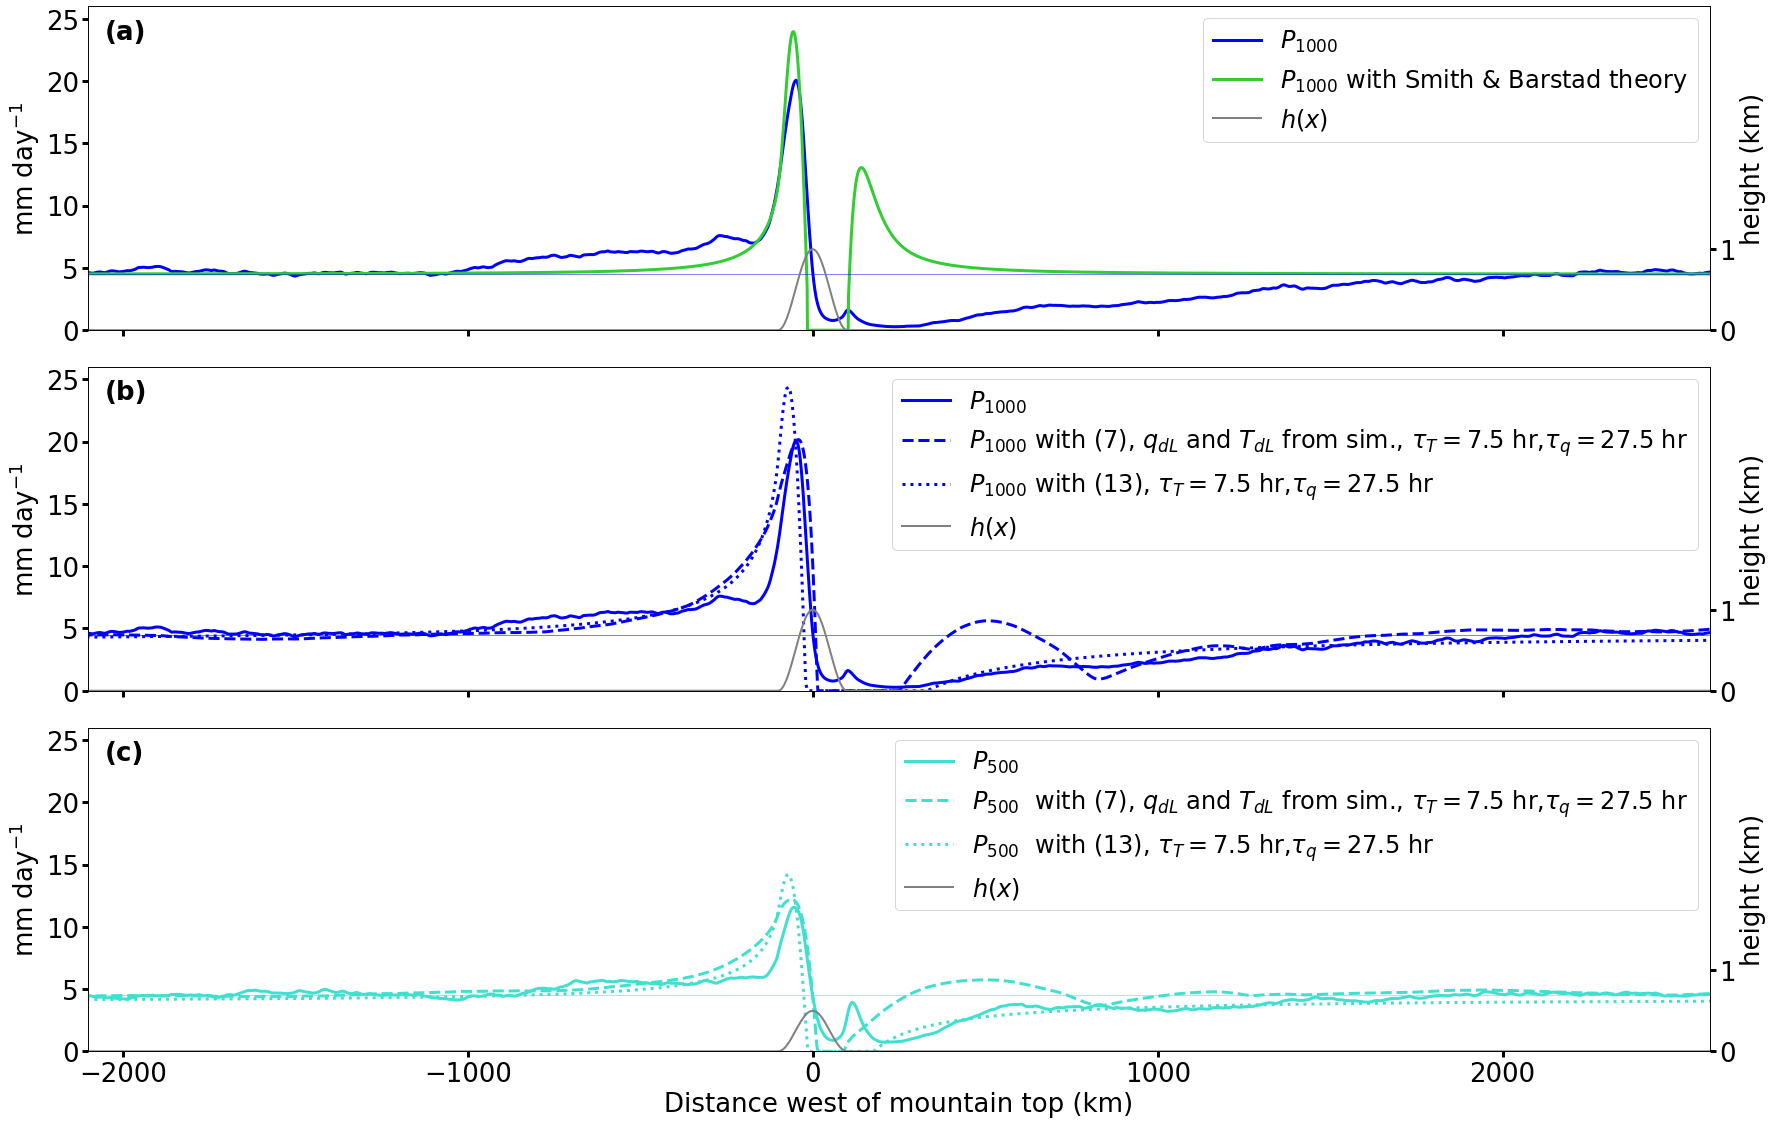

In [14]:
matplotlib.rcParams.update({'font.size': 26})
fig,(ax,ax2,ax3)=plt.subplots(3,1,figsize=(25,16))
axm=ax.twinx()
axm2=ax2.twinx()
axm3=ax3.twinx()

lw=3

# Top panel
ax.plot(hrdist,deeppr,    label=r"$P_{1000}$",color='b',linewidth=lw)
ax.plot(xx2/1000,((Plin_smith-4.5)/2.5+4.5)*(Plin_smith>0), label=r"$P_{1000}$ with Smith & Barstad theory",color='limegreen',linestyle='-',linewidth=lw)

## Middle panel
ax2.plot(hrdist,deeppr,        label=r"$P_{1000}$",color='b',linewidth=lw)
ax2.plot(hrdist,deepPnonlin_fit, label=r"$P_{1000}$ with (7), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle='--',linewidth=lw)
ax2.plot(xx/1000,Plin_fit,    label=r"$P_{1000}$ with (13), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='b',linestyle=':',linewidth=lw)

## Bottom panel
ax3.plot(hrdist,lmdeeppr,          label=r"$P_{500}$",color='turquoise',linewidth=lw)
ax3.plot(hrdist,lmdeepPnonlin_fit, label=r"$P_{500}$  with (7), $q_{dL}$ and $T_{dL}$ from sim., $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle='--',linewidth=lw)
ax3.plot(xx/1000,Plin500_fit,   label=r"$P_{500}$  with (13), $\tau_T=7.5$ hr,$\tau_q=27.5$ hr",color='turquoise',linestyle=':',linewidth=lw)


ax.set_ylim(0,26)
ax2.set_ylim(0,26)
ax3.set_ylim(0,26)

for i,(a,am) in enumerate(zip((ax,ax2,ax3),(axm,axm2,axm3))):
    a.set_ylabel(r'mm day$^{-1}$')
    a.set_xlim(-2.1e3,2.6e3)
    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if i==2:
        a.set_xlabel('Distance west of mountain top (km)')
        a.axhline(4.5,linestyle='-',linewidth=0.5,color='turquoise')
        am.plot(hrdist,hrhgt/1000/2,label=r"$h(x)$",color='gray',linewidth=2)
    else:
        ticks=range(-2000,3000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))
        a.axhline(4.5,linestyle='-',linewidth=0.5,color='b')
        am.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)
    
    am.set_ylabel('height (km)')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=1,fontsize=24)
fig.tight_layout(pad=0.8)
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.9,'(b)', transform=ax2.transAxes,color='k',weight='bold')
ax3.text(0.01, 0.9,'(c)', transform=ax3.transAxes,color='k',weight='bold')

fig.savefig('/global/homes/q/qnicolas/orographicConvectionTheory/figures_review/Pcompare.eps',bbox_inches='tight')

# Figure 9 - evaporation and radiative cooling profiles

In [28]:
hrhfx  = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.HFX.days50-200.mean.nc")
hrradc = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.radiativecooling.days50-200.mean.nc")
hrevap = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.QFX.days50-200.mean.nc")
lmradc = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.500m.3km.radiativecooling.days50-200.mean.nc")
lmevap = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.500m.3km.QFX.days50-200.mean.nc")

In [29]:
tmean_p    = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.T_PL.days50-200.mean.nc")
lmtmean_p  = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.500m.3km.T_PL.days50-200.mean.nc")
dryqmean_p = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.dry.3km.Q_PL.days50-200.mean.nc")
tmean_p_hat_prime         = hatprime(tmean_p,0,7)
lmtmean_p_hat_prime = hatprime(lmtmean_p,0,7)
dryqmean_p_hat_prime      = Lc/cp*hatprime(dryqmean_p,0,7) # convert to K


In [30]:
%%time
#Compute alpha, the relative deviation in P_0, defined such that P_0(x) = constantP0(1+alpha(x)). See definition of P_0 in eqn (5)
Ms = 2370
Mh = 455
Mq = Ms-Mh

hrevap_prime = hrevap/hrevap[2000:3000].mean() - 1
hrradc_prime = hrradc/hrradc[2000:3000].mean() - 1
hralpha_evap_rad = np.array((Ms*hrevap_prime-Mq*hrradc_prime)/Mh)[::-1]

Ms = 2341
Mh = 450
Mq = Ms-Mh

lmevap_prime = lmevap/lmevap[2000:3000].mean() - 1
lmradc_prime = lmradc/lmradc[2000:3000].mean() - 1
lmalpha_evap_rad = np.array((Ms*lmevap_prime-Mq*lmradc_prime)/Mh)[::-1]

#Precip predicted by nonlinear theory with adapted evap&radiative cooling
Pnonlin_e   = nonlinear_precip_theory(1000*hrdist[::-1],np.array(tmean_p_hat_prime)[::-1  ],np.array(dryqmean_p_hat_prime)[::-1]  ,10,tauT=7.5,tauq=27.5,P0=4.5,alpha=hralpha_evap_rad)[::-1]
lmPnonlin_e = nonlinear_precip_theory(1000*hrdist[::-1],np.array(lmtmean_p_hat_prime)[::-1],np.array(dryqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5,P0=4.5,alpha=lmalpha_evap_rad)[::-1]

hrpr=xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")
lmpr=xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.500m.3km.precip.days50-200.mean.nc")

CPU times: user 12 s, sys: 8.23 ms, total: 12 s
Wall time: 12 s


In [16]:
deephfx   = deepchannel.HFX.isel(Time=slice(400,1000)).mean(['south_north','Time']).persist()

In [17]:
%%time
def rad_cooling(sim,t1,t2):
    mSWUPT = (sim.ACSWUPT.isel(Time = t2)-sim.ACSWUPT.isel(Time = t1))/(t2-t1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = t2)-sim.ACSWDNT.isel(Time = t1))/(t2-t1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = t2)-sim.ACSWUPB.isel(Time = t1))/(t2-t1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = t2)-sim.ACSWDNB.isel(Time = t1))/(t2-t1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = t2)-sim.ACLWUPT.isel(Time = t1))/(t2-t1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = t2)-sim.ACLWDNT.isel(Time = t1))/(t2-t1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = t2)-sim.ACLWUPB.isel(Time = t1))/(t2-t1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = t2)-sim.ACLWDNB.isel(Time = t1))/(t2-t1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB
deepradc = rad_cooling(deepchannel,400,1000).mean(['south_north']).load()
deepevap = deepchannel.QFX.isel(Time=slice(400,1000)).mean(['south_north','Time']).load()

CPU times: user 1.17 s, sys: 5.91 s, total: 7.09 s
Wall time: 8.27 s


In [26]:

change_coords_sfc(deepradc).to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.radiativecooling2.days50-200.mean.nc")

In [19]:
%%time
lmdeepradc = rad_cooling(lmdeepchannel,200,800).mean(['south_north']).load()
lmdeepevap = lmdeepchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time']).load()

CPU times: user 1.41 s, sys: 15.1 s, total: 16.5 s
Wall time: 44.8 s


In [25]:
change_coords_sfc(deephfx).to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.HFX.days50-200.mean.nc")
change_coords_sfc(deepevap).to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.QFX.days50-200.mean.nc")
change_coords_sfc(lmdeepradc).to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.500m.3km.radiativecooling.days50-200.mean.nc")
change_coords_sfc(lmdeepevap).to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.500m.3km.QFX.days50-200.mean.nc")



In [23]:
%%time
#Compute alpha, the relative deviation in P_0, defined such that P_0(x) = constantP0(1+alpha(x)). See definition of P_0 in eqn (5)
Ms = 2370
Mh = 455
Mq = Ms-Mh

deepevap_prime = deepevap/deepevap[2000:3000].mean() - 1
deepradc_prime = deepradc/deepradc[2000:3000].mean() - 1
deepalpha_evap_rad = np.array((Ms*deepevap_prime-Mq*deepradc_prime)/Mh)[::-1]

Ms = 2341
Mh = 450
Mq = Ms-Mh

lmdeepevap_prime = lmdeepevap/lmdeepevap[2000:3000].mean() - 1
lmdeepradc_prime = lmdeepradc/lmdeepradc[2000:3000].mean() - 1
lmdeepalpha_evap_rad = np.array((Ms*lmdeepevap_prime-Mq*lmdeepradc_prime)/Mh)[::-1]

#Precip predicted by nonlinear theory with adapted evap&radiative cooling
deepPnonlin_e   = nonlinear_precip_theory(1000*hrdist[::-1],np.array(deeptmean_p_hat_prime)[::-1  ],np.array(drydeepqmean_p_hat_prime)[::-1]  ,10,tauT=7.5,tauq=27.5,P0=4.5,alpha=deepalpha_evap_rad)[::-1]
lmdeepPnonlin_e = nonlinear_precip_theory(1000*hrdist[::-1],np.array(lmdeeptmean_p_hat_prime)[::-1],np.array(drydeepqmean_p_hat_prime)[::-1]/2,10,tauT=7.5,tauq=27.5,P0=4.5,alpha=lmdeepalpha_evap_rad)[::-1]

CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 12.5 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


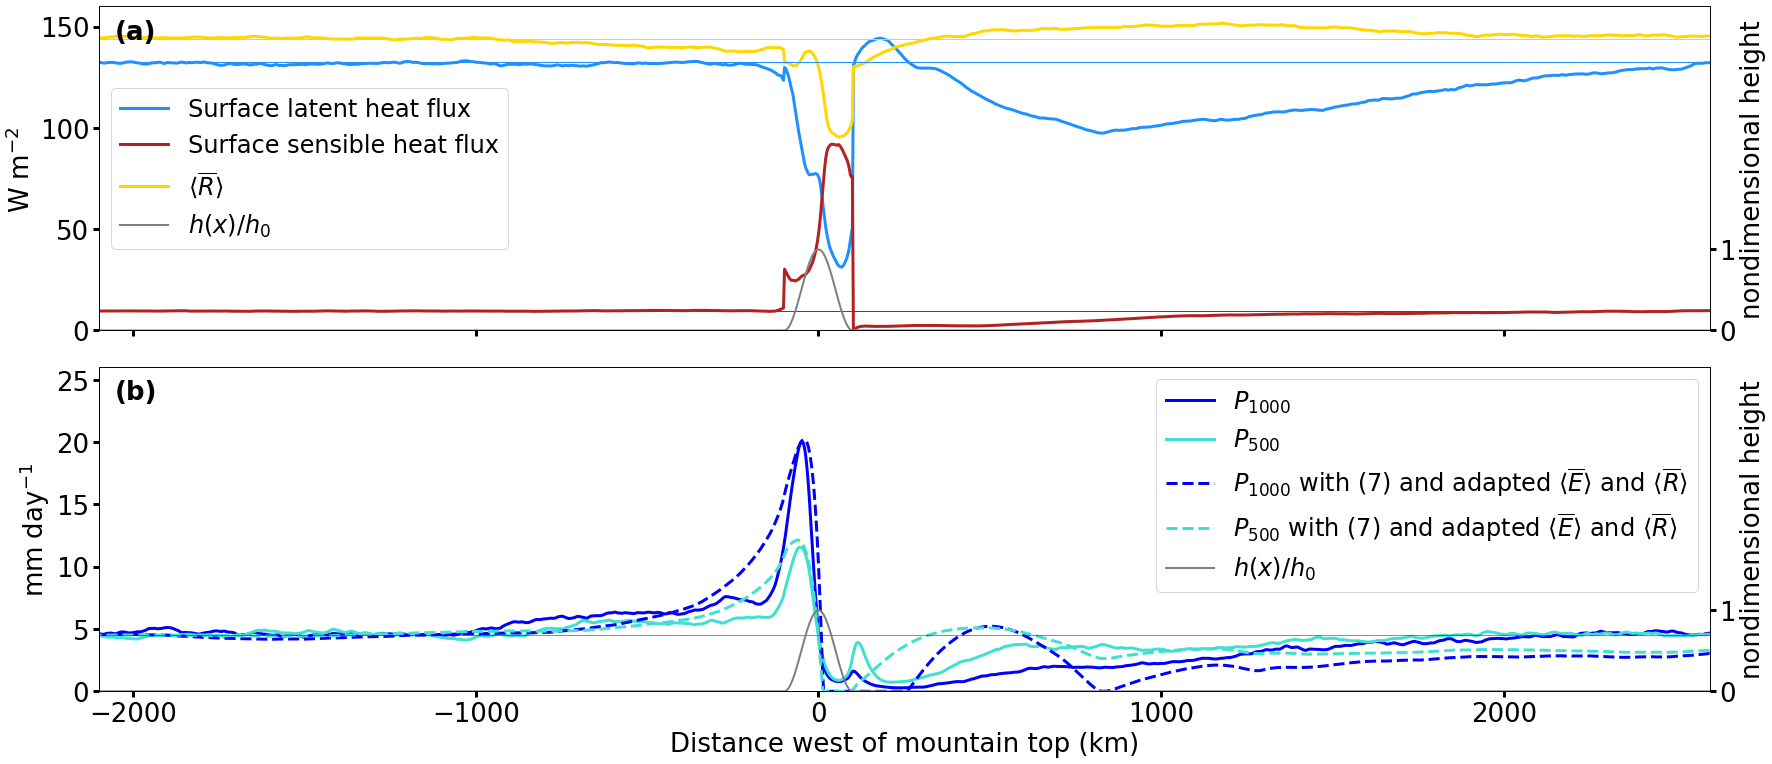

In [31]:
matplotlib.rcParams.update({'font.size': 26})
fig,(ax,ax2)=plt.subplots(2,1,figsize=(25,11))
axm=ax.twinx()
axm2=ax2.twinx()

lw=3
lwl=1

## Top panel - fluxes
ax.plot(hrdist,Lc*deepevap, label=r"Surface latent heat flux",color='dodgerblue',linewidth=lw)
ax.plot(hrdist,deephfx, label=r"Surface sensible heat flux",color='firebrick',linewidth=lw)
ax.plot(hrdist,deepradc, label=r"$\langle\overline{R}\rangle$",color='gold',linewidth=lw)
ax.axhline(Lc*deepevap[2200:3000].mean(),linestyle='-',linewidth=lwl,color='dodgerblue')
ax.axhline(deephfx[2200:3000].mean(),linestyle='-',linewidth=lwl,color='firebrick')
ax.axhline(deepradc[2200:3000].mean(),linestyle='-',linewidth=lwl,color='gold')
ax.set_ylabel(r'W m$^{-2}$')
ax.set_ylim(0,160)

## Bottom panel
ax2.plot(hrdist,deeppr,         label=r"$P_{1000}$",color='b',linewidth=lw)
ax2.plot(hrdist,lmdeeppr,       label=r"$P_{500}$",color='turquoise',linewidth=lw)
ax2.plot(hrdist,deepPnonlin_e  ,label=r"$P_{1000}$ with (7) and adapted $\langle\overline{E}\rangle$ and $\langle\overline{R}\rangle$",color='b',linestyle='--',linewidth=lw)
ax2.plot(hrdist,lmdeepPnonlin_e,label=r"$P_{500}$ with (7) and adapted $\langle\overline{E}\rangle$ and $\langle\overline{R}\rangle$",color='turquoise',linestyle='--',linewidth=lw)

ax2.axhline(4.5,linestyle='-',linewidth=0.5,color='b')
ax2.set_ylabel(r'mm day$^{-1}$')
ax2.set_ylim(0,26)

for i,(a,am) in enumerate(zip((ax,ax2),(axm,axm2))):
    am.plot(hrdist,hrhgt/1000,label=r"$h(x)/h_0$",color='gray',linewidth=2)
    
    a.set_xlim(-2.1e3,2.6e3)
    a.tick_params(width=3,length=6)
    am.tick_params(width=3,length=6)
    
    if i==1:
        a.set_xlabel('Distance west of mountain top (km)')
    else:
        ticks=range(-2000,3000,1000)
        a.set_xticks(ticks)
        a.set_xticklabels([""]*len(ticks))
    
    am.set_ylabel('nondimensional height')
    am.set_ylim(0,4)
    am.set_yticks([0,1])
    
    lines, labels = a.get_legend_handles_labels()
    lines2, labels2 = am.get_legend_handles_labels()
    a.legend(lines + lines2, labels + labels2, loc=0,fontsize=24)
    
ax.text(0.01, 0.9,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 0.9,'(b)', transform=ax2.transAxes,color='k',weight='bold')

fig.tight_layout(pad=0.8)
fig.savefig('/global/homes/q/qnicolas/orographicConvectionTheory/figures_review/evaprad.eps',bbox_inches='tight')

# Figure B1 - hovmoeller diagram of precipitation

In [138]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [27]:
deepchannelprecip_hourly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.hourly.days0-250.nc')
deepchannelprecip_hov_all = change_coords_sfc(deepchannelprecip_hourly[1200:].mean('south_north'))
#deepchannelprecip_hov_all.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.precip.days50-200.hourly_meridionalmean.nc")

In [53]:
from dask.distributed import Client
client=Client()

In [56]:
#%%time
#def select_hov_t(t0,t,d):
#    return ((t>=t0-.5+(d+4902)/36) & (t<=t0+.5+(d+4902)/36))
#
#n=len(deepchannelprecip_hov_all.Time)-300
#p_charac=np.zeros(n)
#for t in range(n):
#    if t%25==0:
#        print(t,end=' ')
#    p_charac[t] = float(deepchannelprecip_hov_all.where(select_hov_t(t,deepchannelprecip_hov_all.Time,deepchannelprecip_hov_all.distance_from_mtn))[t:t+300].mean())
#
#p_charac = xr.DataArray(p_charac,coords={'Time':deepchannelprecip_hov_all.Time[:-300]},dims=['Time'])
#p_charac.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.pcharac.days100-238.nc")




0 25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900 925 950 975 1000 1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425 1450 1475 1500 1525 1550 1575 1600 1625 1650 1675 1700 1725 1750 1775 1800 1825 1850 1875 1900 1925 1950 1975 2000 2025 2050 2075 2100 2125 2150 2175 2200 2225 2250 2275 2300 2325 2350 2375 2400 2425 2450 2475 2500 2525 2550 2575 2600 2625 2650 2675 2700 2725 2750 2775 2800 2825 2850 2875 2900 2925 2950 2975 3000 3025 3050 3075 3100 3125 3150 3175 3200 3225 3250 3275 3300 3325 3350 3375 3400 3425 3450 3475 3500 3525 3550 3575 3600 3625 3650 3675 3700 3725 3750 3775 3800 3825 3850 3875 3900 3925 3950 3975 4000 4025 4050 4075 4100 4125 4150 4175 4200 4225 4250 4275 4300 4325 4350 4375 4400 4425 4450 4475 CPU times: user 6min 54s, sys: 3min 45s, total: 10min 40s
Wall time: 10min


In [31]:
p_charac = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.pcharac.days100-238.nc")
#p_charac.to_netcdf("/global/homes/q/qnicolas/orographicConvectionTheory/data_review/wrf.100x2.mountain.3km.precip_characteristiclines.days50-188.nc")

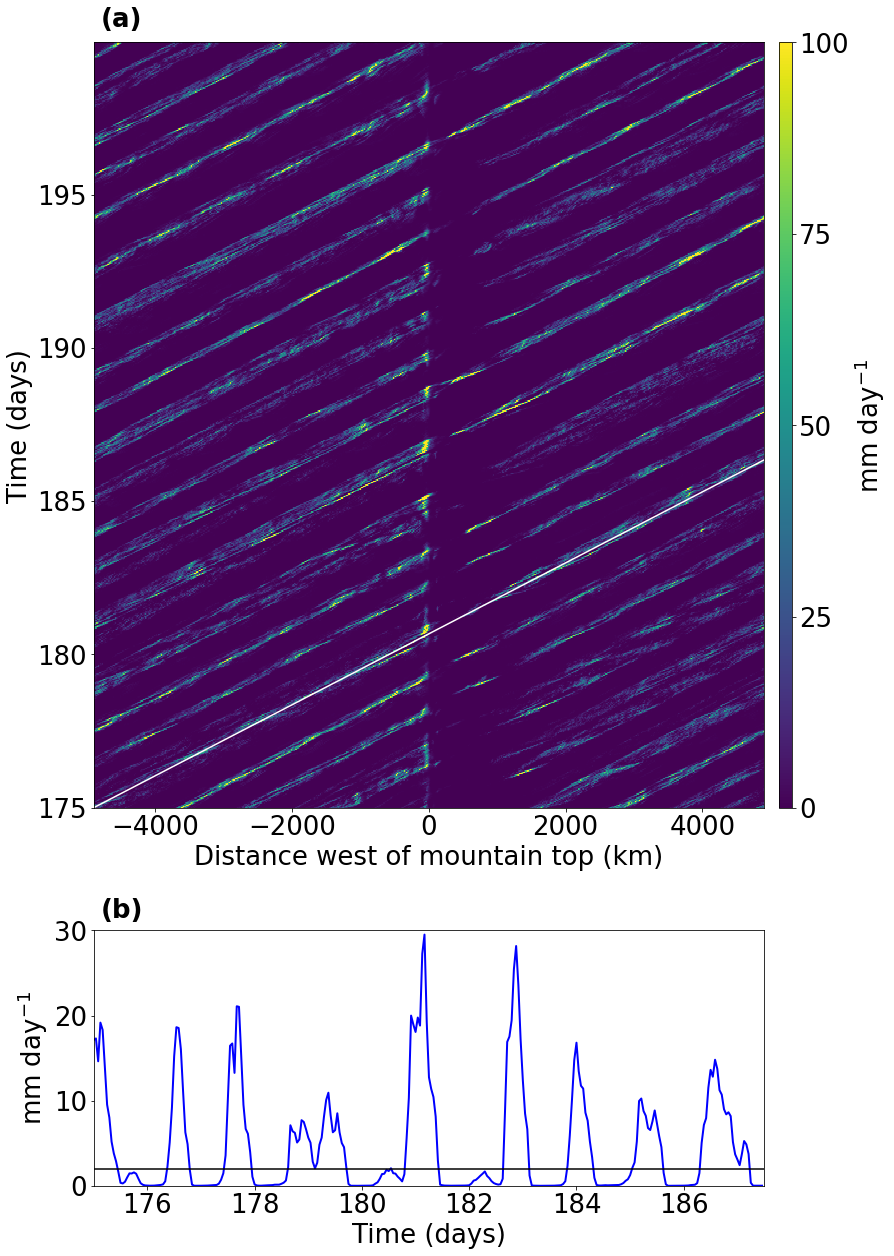

In [141]:
matplotlib.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=(13,18))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3,1],figure=fig)
ax = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

c=deepchannelprecip_hov_all[-600:].plot(ax=ax,vmax=100,add_colorbar=False)#,cbar_kwargs={'pad':0.2,'label':r'mm day$^{-1}$'})
ax.plot(deepchannelprecip_hov_all.distance_from_mtn,(deepchannelprecip_hov_all.distance_from_mtn+4902)*1000/(10*3600),color='w')
    
pad=.2;size="2%"
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'mm day$^{-1}$',ticks=np.arange(0,101,25))
#cax.tick_params(labelsize=20)

ax2.plot(p_charac[-300:], color='b',linewidth=2)
ax2.axhline(2.,color='k')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel('Time (days)')
ax.set_yticks(range(0,600,24*5))
ax.set_yticklabels(np.arange(0,600,24*5)//24+175)

ax2.set_ylabel(r'$t$')
ax2.set_ylabel(r'mm day$^{-1}$')

ax2.set_xlabel('Time (days)')
ax2.set_ylabel(r'mm day$^{-1}$')
ax2.set_xlim(0,300)
ax2.set_ylim(0,30)
ax2.set_xticks(range(24,300,24*2))
ax2.set_xticklabels(np.arange(24,300,24*2)//24+175)

ax.text(0.01, 1.02,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 1.05,'(b)', transform=ax2.transAxes,color='k',weight='bold')


fig.tight_layout()
fig.savefig('/global/u2/q/qnicolas/orographicConvectionTheory/figures_review/figB1.png', dpi=300 ,bbox_inches='tight')


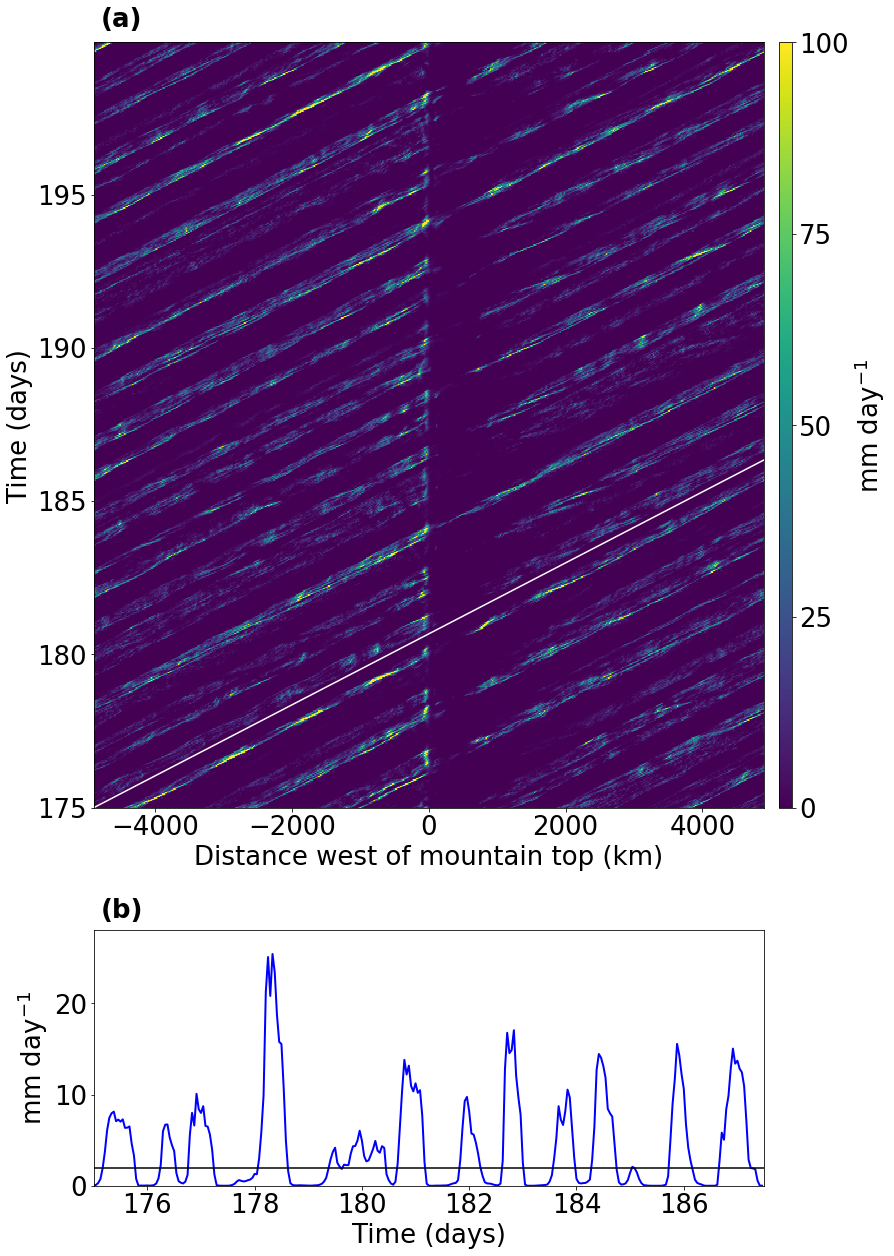

In [147]:
matplotlib.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=(13,18))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3,1],figure=fig)
ax = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

c=hrchannelprecip_hov_all[-600:].plot(ax=ax,vmax=100,add_colorbar=False)#,cbar_kwargs={'pad':0.2,'label':r'mm day$^{-1}$'})
ax.plot(hrchannelprecip_hov_all.distance_from_mtn,(hrchannelprecip_hov_all.distance_from_mtn+4902)*1000/(10*3600),color='w')
    
pad=.2;size="2%"
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'mm day$^{-1}$',ticks=np.arange(0,101,25))
#cax.tick_params(labelsize=20)

ax2.plot(p_charac[-300:], color='b',linewidth=2)
ax2.axhline(2.,color='k')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel('Time (days)')
ax.set_yticks(range(0,600,24*5))
ax.set_yticklabels(np.arange(0,600,24*5)//24+175)

ax2.set_ylabel(r'$t$')
ax2.set_ylabel(r'mm day$^{-1}$')

ax2.set_xlabel('Time (days)')
ax2.set_ylabel(r'mm day$^{-1}$')
ax2.set_xlim(0,300)
ax2.set_ylim(0,28)
ax2.set_xticks(range(24,300,24*2))
ax2.set_xticklabels(np.arange(24,300,24*2)//24+175)

ax.text(0.01, 1.02,'(a)', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 1.05,'(b)', transform=ax2.transAxes,color='k',weight='bold')


fig.tight_layout()
fig.savefig('/global/u2/q/qnicolas/orographicPrecipitation/paperFigures/figB1.png', dpi=300 ,bbox_inches='tight')


# Figure B2 - Mean precipitation over rainy times only

In [143]:
from functools import reduce
def select_hov_all(t,d):
    return reduce(lambda x,y:x|y,[(t>=t1+(d+4902)/36) & (t<=t2+(d+4902)/36) for t1,t2 in zip(begs,ends)])


In [57]:
hrpr_hovmoller_all = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip.days50-200.hourly_meridionalmean.nc")
p_characteristic = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip_characteristiclines.days50-188.nc")


In [59]:
thresh_crossings=np.arange(len(p_characteristic)-1)[np.diff(p_characteristic>2)]
ends=thresh_crossings[1::2]+1
begs=thresh_crossings[::2][:len(ends)]


hrpr_rainy=hrpr_hovmoller_all.where(select_hov_all(hrpr_hovmoller_all.Time,hrpr_hovmoller_all.distance_from_mtn)).mean('Time')
hrpr=xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")

In [144]:
thresh_crossings=np.arange(len(p_charac)-1)[np.diff(p_charac>2)]
ends=thresh_crossings[1::2]+1
begs=thresh_crossings[::2][:len(ends)]
deeppr_rainy=deepchannelprecip_hov_all.where(select_hov_all(deepchannelprecip_hov_all.Time,deepchannelprecip_hov_all.distance_from_mtn)).mean('Time')

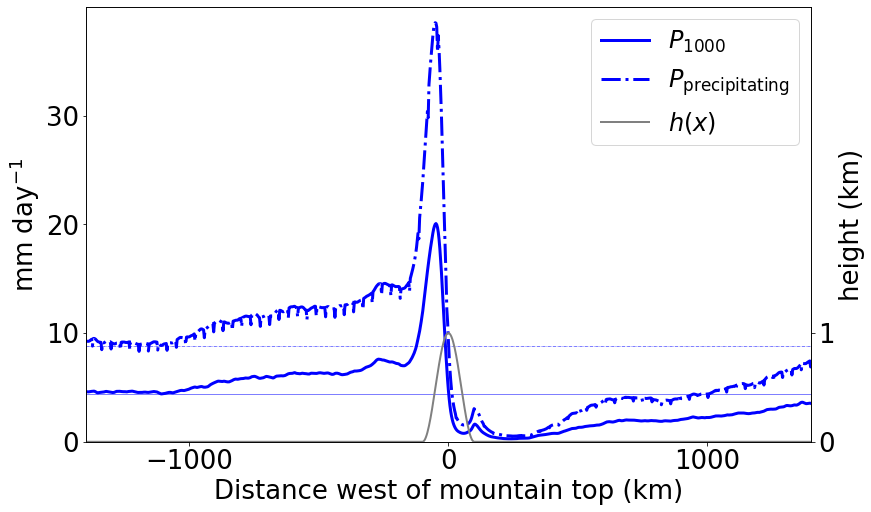

In [145]:
matplotlib.rcParams.update({'font.size': 26})

lw=3

fig,ax=plt.subplots(1,1,figsize=(13,8))
ax2=ax.twinx()

# precips
ax.plot(hrdist,deeppr,      label=r"$P_{1000}$",color='b',linewidth=lw)
ax.plot(hrdist,deeppr_rainy,label=r"$P_\mathrm{precipitating}$",color='b',linestyle='-.',linewidth=lw)

# mountain
ax2.plot(hrdist,hrhgt/1000,label=r"$h(x)$",color='gray',linewidth=2)

ax.axhline(4.4,linestyle='-',linewidth=0.5,color='b')
ax.axhline(8.8,linestyle='-.',linewidth=0.5,color='b')
ax.set_xlabel('Distance west of mountain top (km)')
ax.set_ylabel(r'mm day$^{-1}$')
ax.set_xlim(-1.4e3,1.4e3)
ax.set_ylim(0,40)
ax.set_yticks(range(0,40,10))
ax.set_xticks(range(-1000,1001,1000))

ax2.set_ylabel('height (km)')
ax2.set_ylim(0,4)
ax2.set_yticks([0,1])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0,fontsize=24)

fig.savefig('/global/u2/q/qnicolas/orographicConvectionTheory/figures_review/figB2.png',bbox_inches='tight')